In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
%matplotlib inline
import tqdm.notebook
tqdm = tqdm.notebook.tqdm
from IPython.display import display

In [2]:
import therpy as tp 
divide_axes = tp.divide_axes
sdict = tp.sdict

The servers are not connected!
Using the local database copy. Could be outdated!


# Prior to 12/21/2019

In [5]:
'''
curve fitting
=============
'''
class curve_fit:
    '''
    Least square curve fitting to {x,y} data
    ========================================
    Inputs Required :
        fitfun - python function with inputs (of type x_data, p0, p1, p2, p3, ...) and returns np.array y_data
        guess  - could be a simple list, or more detailed dict (see below for more info)
        x_data - I think this could be anything supported by fitfun input, to be safe, keep it np.array
        y_data - must be np.array

    Inputs Optional :
        y_err - sigma for the y_data, defaults to np.ones_like(y_data). The following is optimized sum ( (y_data-fitfun(...))/y_err )^2
        fixed - dict(gradient = 0, tau = 5, ...) : parameters to fix. NOTE: if guess contains the same key, that key will not be fixed
        plot  - True / False : Plots a standard figure with data, fit line, residuals
        info  - True / False : print(self.fr)

    guess :
        1) guess = [12, 3, -np.pi, ...] : a simple list
        2) guess = [ [12, (10, 14), 'meter'], 3, [np.pi, (0, 2*np.pi)], ...] : mixture of simple value and fancy list
        A fancy list for a guess contains up to three items -- the guess value itself, a tuple for lower and upper bounds, a string for units
        A fancy list must contain the guess itself, but the other two things are optional
        3) guess = dict(tau = 12, phase = [np.pi, (0, 2*np.pi), 'radians'], ...) : a dictionary containing mixture of simple value and fancy list

    MUST DO :
        - Make sure x_data, y_data, and y_err is valid for fitfun input/output and DOES NOT contain inf or nan.

    Properties : self.xxxxxx
        x, y, y_err, success, fitfun
        fr : pandas dataframe of the fitresults
        fv : indexable sdict of fit values with parameters as keys, including the fixed and default parameters
        fe : indexable sdict of fit errors with parameters as keys, including the fixed and default parameters
        ul : indexable sdict of upper limit of fit values with parameters as keys, including the fixed and default parameters
        ll : indexable sdict of lower limit of fit values with parameters as keys, including the fixed and default parameters
        xp : finely spaced grid for same x range : np.linspace(self.x.min(), self.x.max(), 1000)
        ye : short form for y_err

    Special Methods :
        __call__ : returns fitted curve at optionally provided x and overridden parameters : self(), self(x, phase=0, amp=0, ...), self(self.xp),
        __len__ : len(self) returns the number of parameters the fitfun takes
        __getitem__ : self['amp'] or self[1] : returns the fir value for given key or index
        __setitem__ : self['amp'] = 0 or self[1] = 0 : fixes the
        __bool__ : if self: or bool(self) : true if the fit was successful
        __repr__ or __str__ : str(self) or print(self) : returns the fitresults in printable format

    Methods : self.xxx(aa=yy, bb=yy, ..)
        yband(x = None, using=[]) :
        plot()
            two plots, data and fit curve on top, and residuals below. Optional inputs
            ax : to plot somewhere specific
            fiterrors = False : include fit error band along with optimal fit
            using = [] : which parameters to sue to calculate fiterrors band
            divider = 0.25 : how to split the axes for residuals
        plot_fitdata(ax=None, x=None) : data and fit curve
        plot_residuals(ax=None) : residuals
        plot_residuals_hist(ax=None, orientation='vertical) : histogram of the residuals
        plot_fiterrors(ax=None, x=None, using=[]) : fit error band, optinally include only keys in using
    '''
    def __init__(self, fitfun, guess, x_data, y_data, y_err=None, fixed=dict(), plot=False, info=False):
        ''' init will fit the data and save fitresults '''
        ### Verify inputs
        if not callable(fitfun): print("provided fitfun is not valid python function!")

        ### Process single item from guess -- return guess value, bounds, units
        def temp_process_guess_item(item):
            units, bounds = None, [-np.inf, np.inf] # default value
            if type(item) in [list, tuple, np.ndarray]:
                value = item[0]
                if len(item) > 3: return [value, bounds, units]
                for i in item[1:]:
                    if type(i) is str: units = i
                    elif type(i) in [list, tuple, np.ndarray]: bounds = i
            else: value = item
            return [value, bounds, units]

        ### Process guess -- generate guess_keys, guess_values, guess_bounds, guess_units
        # the order of keys will be determined by the order of fitfun input order
        if type(guess) == dict:
            guess_keys = [k for k in fitfun.__code__.co_varnames[1:fitfun.__code__.co_argcount] if k in list(guess.keys())]
            temp_ = [temp_process_guess_item(guess[k]) for k in guess_keys]
        elif type(guess) in [list, tuple, np.ndarray]:
            guess_keys = fitfun.__code__.co_varnames[1:1+len(guess)]
            temp_ = [temp_process_guess_item(i) for i in guess]
        elif (type(guess) in [float, int]) or (np.issubdtype(guess, np.number)):
            guess_keys = fitfun.__code__.co_varnames[1:2]
            temp_ = [temp_process_guess_item(guess)]
        else:
            print('Does NOT understand data type of guess : ', guess)
        guess_values, guess_bounds, guess_units = np.array([i[0] for i in temp_]), np.array([i[1] for i in temp_]).T, [i[2] for i in temp_]

        ### Extract all fixed items, including provided and default ones
        fixed_func_defaults = {k:v for k, v in zip(fitfun.__code__.co_varnames[-len(fitfun.__defaults__):fitfun.__code__.co_argcount], fitfun.__defaults__)}
        fixed_dict = {**fixed_func_defaults, **fixed}
        for k in guess_keys: fixed_dict.pop(k, None)

        ### Define temp fitfun for internal use only
        def fitfun_args(x, *args):
            return fitfun(x, **{k: v for k, v in zip(guess_keys, args)}, **fixed_dict)

        ### Fit Data
        success = False
        try:
            fv_, fe_ = scipy.optimize.curve_fit(fitfun_args, x_data, y_data, guess_values, sigma=y_err, bounds=guess_bounds)
            fe_ = np.sqrt(np.diag(fe_))
            success = True
        except (ValueError, RuntimeError) as err:
            fv_, fe_ = guess_values, guess_values*np.nan
            print("CAN'T FIT, Returning Original Guess: Details of Error :: {}".format(err))

        ### Formatting Fit Results
        fitresults_dict = dict(FitValue=fv_, FitError=fe_, Units=guess_units, Guess=guess_values, LowerBound=guess_bounds[0], UpperBound=guess_bounds[1])
        fitresults_df = pd.DataFrame(fitresults_dict, index=guess_keys, columns=['FitValue','FitError','Units','Guess','LowerBound','UpperBound'])
        for k, v in fixed_dict.items(): fitresults_df.loc[k] = [v, 0, None, v, v, v]
        fitresults_df = fitresults_df.loc[fitfun.__code__.co_varnames[1:fitfun.__code__.co_argcount], :] # sort the index by function input list
        fitresults_df['FitError%'] = np.nan_to_num(np.abs(fitresults_df['FitError'] / fitresults_df['FitValue'])) * 100

        ### Store results to self
        self.fr = fitresults_df
        self.fitfun = fitfun
        self.success = success
        self.x = x_data
        self.y = y_data
        self.y_err = y_err

        ### Plots and display
        if plot: self.plot()
        if info: print(self)

    @property
    def fv(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values))
    @property
    def fe(self): return sdict(zip(self.fr.index.values, self.fr['FitError'].values))
    @property
    def ul(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values + self.fr['FitError'].values))
    @property
    def ll(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values - self.fr['FitError'].values))
    @property
    def xp(self): return np.linspace(self.x.min(), self.x.max(), 1000)
    @property
    def ye(self): return self.y_err

    def __call__(self, *args, **kwargs):
        '''get the fit line evaluated at *args (self.x) with **kwargs overridden'''
        x = args[0] if len(args) == 1 else self.x
        return self.fitfun(x, **{**self.fv, **kwargs})
    def __len__(self): return len(self.fv)
    def __getitem__(self, key):
        if (type(key) in [int, float]): return self.fv[int(key)]
        elif type(key) == str: return self.fv.get(key, None)
    def __setitem__(self, key, value):
        if type(key) in [int, float]: key = self.fr.index.values[int(key)]
        r = self.fr.loc[key].values
        r[0], r[1], r[6] = value, 0, 0
        self.fr.loc[key] = r
    def __bool__(self): return self.success
    def __repr__(self): return self.fr.to_string()
    def __str__(self): return self.fr.to_string()

    def yband(self, x=None, using=[]):
        '''Return (y_min, y_max) at x including using list of fit errors'''
        if x is None: x = self.x
        if type(using) == str: using = [using,]
        if len(using) == 0: using = self.fr.index.values
        ys = [self(x)]
        for k in using:
            ys.append(self(x, **{k : self.fv[k] - self.fe[k]}))
            ys.append(self(x, **{k : self.fv[k] + self.fe[k]}))
        return (np.min(ys, axis=0), np.max(ys, axis=0))
    def plot_fitdata(self, ax=None, x=None):
        '''Plot data and the fitline on ax (or new figure) with x (or self.xp) for fitline'''
        if x is None: x = self.xp
        if ax is None: fig, ax = plt.subplots()
        ax.errorbar(self.x, self.y, self.y_err, fmt='r.-')
        ax.plot(x, self(x), 'k')
        return ax
    def plot_residuals(self, ax=None):
        '''Plot residual with vertical lines and zero line on ax (or new figure)'''
        if ax is None: fig, ax = plt.subplots()
        ax.axhline(0, c='k', alpha=0.5)
        ax.vlines(self.x, self.x*0, self.y-self())
        ax.plot(self.x, self.y-self(), 'r.')
        return ax
    def plot_residuals_hist(self, ax=None, orientation='vertical'):
        '''Plot histogram of the residul on ax (or new figure) with orientation either vertical or horizontal'''
        if ax is None: fig, ax = plt.subplots()
        ax.hist(self.y-self(), orientation=orientation)
        return ax
    def plot_fiterrors(self, ax=None, x=None, using=[]):
        '''Plot a band of y representing fit errors : on ax (or a new figure) with x (or self.ax) and with using list (or all) of fit variables'''
        if x is None: x = self.xp
        ax = self.plot_fitdata(ax)
        ax.fill_between(x, *self.yband(x=x, using=using), color='g', alpha=0.25)
        return ax
    def plot(self, ax=None, x=None, fiterrors=True, using=[], divider=0.25):
        '''Plot data with fitline and '''
        if ax is None: ax = plt.subplots(figsize=[5,5])[1]
        if x is None: x = self.xp
        (ax1, ax2) = divide_axes(ax, divider=divider, direction='vertical', shared=True)
        if fiterrors: self.plot_fiterrors(ax=ax1, x=x, using=using)
        else: self.plot_fitdata(ax=ax1, x=x)
        self.plot_residuals(ax2)
        return (ax1, ax2)

# 12/21/2019

In [47]:
'''
curve fitting
=============
'''
class curve_fit:
    '''
    Least square curve fitting to {x,y} data
    ========================================
    Inputs Required :
        fitfun - python function with inputs (of type x_data, p0, p1, p2, p3, ...) and returns np.array y_data
        guess  - could be a simple list, or more detailed dict (see below for more info)
        x_data - This could be anything supported by fitfun input, to be safe, keep it np.array
        y_data - must be np.array

    Inputs Optional :
        y_err - sigma for the y_data, defaults to np.ones_like(y_data). The following is optimized sum ( (y_data-fitfun(...))/y_err )^2
        fixed - dict(gradient = 0, tau = 5, ...) : parameters to fix. NOTE: if guess contains the same key, that key will not be fixed
        plot  - True / False : Plots a standard figure with data, fit line, residuals
        info  - True / False : print(self.fr)
        disp  - True / False : print(self.fr), info or disp are identical 

    guess :
        1) guess = [12, 3, -np.pi, ...] : a simple list
        2) guess = [ [12, (10, 14), 'meter'], 3, [np.pi, (0, 2*np.pi)], ...] : mixture of simple value and fancy list
        A fancy list for a guess contains up to three items -- the guess value itself, a tuple for lower and upper bounds, a string for units
        A fancy list must contain the guess itself, but the other two things are optional
        3) guess = dict(tau = 12, phase = [np.pi, (0, 2*np.pi), 'radians'], ...) : a dictionary containing mixture of simple value and fancy list

    MUST DO :
        - Make sure x_data, y_data, and y_err is valid for fitfun input/output and DOES NOT contain inf or nan.

    Properties : self.xxxxxx
        x, y, y_err, success, fitfun
        fr : pandas dataframe of the fitresults
        fv : indexable sdict of fit values with parameters as keys, including the fixed and default parameters
        fe : indexable sdict of fit errors with parameters as keys, including the fixed and default parameters
        ul : indexable sdict of upper limit of fit values with parameters as keys, including the fixed and default parameters
        ll : indexable sdict of lower limit of fit values with parameters as keys, including the fixed and default parameters
        xp : finely spaced grid for same x range : np.linspace(self.x.min(), self.x.max(), 1000), if fitfun allows
        ye : short form for y_err

    Special Methods :
        __call__ : returns fitted curve at optionally provided x and overridden parameters : self(), self(x, phase=0, amp=0, ...), self(self.xp),
        __len__ : len(self) returns the number of parameters the fitfun takes
        __getitem__ : self['amp'] or self[1] : returns the fir value for given key or index
        __setitem__ : self['amp'] = 0 or self[1] = 0 : fixes the
        __bool__ : if self: or bool(self) : true if the fit was successful
        __repr__ or __str__ : str(self) or print(self) : returns the fitresults in printable format

    Methods : self.xxx(aa=yy, bb=yy, ..)
        yband(x = None, using=[]) :
        bootstrap(runs=1000, plot=True, **kwargs) 
        plot()
            two plots, data and fit curve on top, and residuals below. Optional inputs
            ax : to plot somewhere specific
            fiterrors = False : include fit error band along with optimal fit
            using = [] : which parameters to sue to calculate fiterrors band
            divider = 0.25 : how to split the axes for residuals
        plot_fitdata(ax=None, x=None) : data and fit curve
        plot_residuals(ax=None) : residuals
        plot_residuals_hist(ax=None, orientation='vertical) : histogram of the residuals
        plot_fiterrors(ax=None, x=None, using=[]) : fit error band, optinally include only keys in using
    '''
    def __init__(self, fitfun, guess, x_data, y_data, y_err=None, fixed=dict(), plot=False, info=False, disp=False):
        ''' init will fit the data and save fitresults '''
        ### Verify inputs
        if not callable(fitfun): print("provided fitfun is not valid python function!")
        # If y_err is not provided, set it to some small number, smaller than the smallers of y
        if y_err == None: y_err = np.ones_like(x_data)*np.min(np.abs(y_data))/100000 
        
        ### Process single item from guess -- return guess value, bounds, units
        def temp_process_guess_item(item):
            units, bounds = None, [-np.inf, np.inf] # default value
            if type(item) in [list, tuple, np.ndarray]:
                value = item[0]
                if len(item) > 3: return [value, bounds, units]
                for i in item[1:]:
                    if type(i) is str: units = i
                    elif type(i) in [list, tuple, np.ndarray]: bounds = i
            else: value = item
            return [value, bounds, units]

        ### Process guess -- generate guess_keys, guess_values, guess_bounds, guess_units
        # the order of keys will be determined by the order of fitfun input order
        if type(guess) == dict:
            guess_keys = [k for k in fitfun.__code__.co_varnames[1:fitfun.__code__.co_argcount] if k in list(guess.keys())]
            temp_ = [temp_process_guess_item(guess[k]) for k in guess_keys]
        elif type(guess) in [list, tuple, np.ndarray]:
            guess_keys = fitfun.__code__.co_varnames[1:1+len(guess)]
            temp_ = [temp_process_guess_item(i) for i in guess]
        elif (type(guess) in [float, int]) or (np.issubdtype(guess, np.number)):
            guess_keys = fitfun.__code__.co_varnames[1:2]
            temp_ = [temp_process_guess_item(guess)]
        else:
            print('Does NOT understand data type of guess : ', guess)
        guess_values, guess_bounds, guess_units = np.array([i[0] for i in temp_]), np.array([i[1] for i in temp_]).T, [i[2] for i in temp_]

        ### Extract all fixed items, including provided and default ones
        fixed_func_defaults = {k:v for k, v in zip(fitfun.__code__.co_varnames[-len(fitfun.__defaults__):fitfun.__code__.co_argcount], fitfun.__defaults__)}
        fixed_dict = {**fixed_func_defaults, **fixed}
        for k in guess_keys: fixed_dict.pop(k, None)

        ### Define temp fitfun for internal use only
        def fitfun_args(x, *args):
            return fitfun(x, **{k: v for k, v in zip(guess_keys, args)}, **fixed_dict)

        ### Fit Data
        success = False
        try:
            fv_, fe_ = scipy.optimize.curve_fit(fitfun_args, x_data, y_data, guess_values, sigma=y_err, bounds=guess_bounds)
            fe_ = np.sqrt(np.diag(fe_))
            success = True
        except (ValueError, RuntimeError) as err:
            fv_, fe_ = guess_values, guess_values*np.nan
            print("CAN'T FIT, Returning Original Guess: Details of Error :: {}".format(err))

        ### Formatting Fit Results
        fitresults_dict = dict(FitValue=fv_, FitError=fe_, Units=guess_units, Guess=guess_values, LowerBound=guess_bounds[0], UpperBound=guess_bounds[1])
        fitresults_df = pd.DataFrame(fitresults_dict, index=guess_keys, columns=['FitValue','FitError','Units','Guess','LowerBound','UpperBound'])
        for k, v in fixed_dict.items(): fitresults_df.loc[k] = [v, 0, None, v, v, v]
        fitresults_df = fitresults_df.loc[fitfun.__code__.co_varnames[1:fitfun.__code__.co_argcount], :] # sort the index by function input list
        fitresults_df['FitError%'] = np.nan_to_num(np.abs(fitresults_df['FitError'] / fitresults_df['FitValue'])) * 100

        ### Store results to self
        self.fr = fitresults_df
        self.fitfun = fitfun
        self.success = success
        self.x = x_data
        self.y = y_data
        self.y_err = y_err
        self.internal_fitfun = fitfun_args 
        self.internal_guess = guess_values 
        self.internal_sigma = y_err 
        self.internal_bounds = guess_bounds 
        self.internal_fv = fv_
        self.internal_keys = guess_keys

        ### Plots and display
        if plot: self.plot()
        if info or disp: print(self)

    @property
    def fv(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values))
    @property
    def fe(self): return sdict(zip(self.fr.index.values, self.fr['FitError'].values))
    @property
    def ul(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values + self.fr['FitError'].values))
    @property
    def ll(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values - self.fr['FitError'].values))
    @property
    def xp(self): 
        xp = np.linspace(self.x.min(), self.x.max(), 1000)
        # If the function always returns a fixed length output independent of the x input 
        if len(self.y) == len(self(xp)): xp = self.x
        return xp
    @property
    def yp(self): return self(self.xp)
    @property
    def ye(self): return self.y_err

    def __call__(self, *args, **kwargs):
        '''get the fit line evaluated at *args (self.x) with **kwargs overridden'''
        x = args[0] if len(args) == 1 else self.x
        return self.fitfun(x, **{**self.fv, **kwargs})
    def __len__(self): return len(self.fv)
    def __getitem__(self, key):
        if (type(key) in [int, float]): return self.fv[int(key)]
        elif type(key) == str: return self.fv.get(key, None)
    def __setitem__(self, key, value):
        if type(key) in [int, float]: key = self.fr.index.values[int(key)]
        r = self.fr.loc[key].values
        r[0], r[1], r[6] = value, 0, 0
        self.fr.loc[key] = r
    def __bool__(self): return self.success
    def __repr__(self): return self.fr.to_string()
    def __str__(self): return self.fr.to_string()

    def yband(self, x=None, using=[]):
        '''Return (y_min, y_max) at x including using list of fit errors'''
        if x is None: x = self.x
        if type(using) == str: using = [using,]
        if len(using) == 0: using = self.fr.index.values
        ys = [self(x)]
        for k in using:
            ys.append(self(x, **{k : self.fv[k] - self.fe[k]}))
            ys.append(self(x, **{k : self.fv[k] + self.fe[k]}))
        return (np.min(ys, axis=0), np.max(ys, axis=0))
    def plot_fitdata(self, ax=None, x=None):
        '''Plot data and the fitline on ax (or new figure) with x (or self.xp) for fitline'''
        if x is None: x = self.xp
        if ax is None: fig, ax = plt.subplots()
        sorti = np.argsort(self.x)
        ax.errorbar(self.x[sorti], self.y[sorti], self.y_err[sorti], fmt='r.-')
        ax.plot(x, self(x), 'k')
        return ax
    def plot_residuals(self, ax=None):
        '''Plot residual with vertical lines and zero line on ax (or new figure)'''
        if ax is None: fig, ax = plt.subplots()
        ax.axhline(0, c='k', alpha=0.5)
        ax.vlines(self.x, self.x*0, self.y-self())
        sorti = np.argsort(self.x)
        ax.plot(self.x[sorti], self.y[sorti]-self()[sorti], 'r.')
        return ax
    def plot_residuals_hist(self, ax=None, orientation='vertical'):
        '''Plot histogram of the residul on ax (or new figure) with orientation either vertical or horizontal'''
        if ax is None: fig, ax = plt.subplots()
        ax.hist(self.y-self(), orientation=orientation)
        return ax
    def plot_fiterrors(self, ax=None, x=None, using=[]):
        '''Plot a band of y representing fit errors : on ax (or a new figure) with x (or self.ax) and with using list (or all) of fit variables'''
        if x is None: x = self.xp
        ax = self.plot_fitdata(ax)
        ax.fill_between(x, *self.yband(x=x, using=using), color='g', alpha=0.25)
        return ax
    def plot(self, ax=None, x=None, fiterrors=True, using=[], divider=0.25):
        '''Plot data with fitline and '''
        if ax is None: ax = plt.subplots(figsize=[5,5])[1]
        if x is None: x = self.xp
        (ax1, ax2) = divide_axes(ax, divider=divider, direction='vertical', shared=True)
        if fiterrors: self.plot_fiterrors(ax=ax1, x=x, using=using)
        else: self.plot_fitdata(ax=ax1, x=x)
        self.plot_residuals(ax2)
        return (ax1, ax2)
    def bootstrap(self, runs=1000, plot=False, info=False, disp=False):
        # Fit runs many times 
        fvs = []
        failed_count = 0
        for i in tqdm(range(runs)):
            usei = np.arange(self.x.size)
            usei = np.random.choice(usei, usei.size)
            try:
                fv_ = scipy.optimize.curve_fit(self.internal_fitfun, self.x[usei], self.y[usei], 
                        self.internal_fv, sigma=self.internal_sigma, bounds=self.internal_bounds)[0]
                fvs.append(fv_)
            except (ValueError, RuntimeError) as err:
                failed_count += 1 
        fvs = np.array(fvs)
        if failed_count > 0: print("Fit failed {} times.".format(failed_count))
        # Extract useful information 
        bs_raw = pd.DataFrame(fvs)
        percentiles = np.array([0.5-0.9545/2, 0.5-0.6827/2, 0.5+0.6827/2, 0.5+0.9545/2]) # Confidence intervals at -2,-1,1,2 sigma 
        bs_percentiles = bs_raw.quantile(q=percentiles)
        bsresults_dict = dict(mean=bs_raw.mean().values, std=bs_raw.std().values)
        bsresults_df = pd.DataFrame(bsresults_dict, index=self.internal_keys, columns=['mean','std'])
        bsresults_df['std%'] = bsresults_df['std'] / np.abs(bsresults_df['mean']) * 100
        bsresults_df['std%'][bsresults_df['std%'] > 999] = 999
        bsresults_df['-2 sigma'] = bs_percentiles.iloc[0,:].values
        bsresults_df['-1 sigma'] = bs_percentiles.iloc[1,:].values
        bsresults_df['+1 sigma'] = bs_percentiles.iloc[2,:].values
        bsresults_df['+2 sigma'] = bs_percentiles.iloc[3,:].values
        
        # Store results 
        self.bs_all = bs_raw
        self.bs = bsresults_df
        # Plot 
        if info or disp: print(self.bs)
        if plot: return self.plot_bootstrap()
    def plot_bootstrap(self, bins=50, color='gray', alpha=1, figsize=None, 
                   grid=True, ax=None, density=True):
        ax = self.bs_all.hist(grid=grid, ax=ax, figsize=figsize, color=color, 
                              alpha=alpha, bins=bins, density=density).flatten()
        for i in range(len(self.bs)):
            ax[i].axvline(self.bs['mean'].iloc[i], color='k', zorder=0, alpha=1)
            ax[i].axvspan(self.bs['-1 sigma'].iloc[i], self.bs['+1 sigma'].iloc[i], color='g', zorder=-1, alpha=0.25)
            ax[i].axvspan(self.bs['-2 sigma'].iloc[i], self.bs['-1 sigma'].iloc[i], color='b', zorder=-2, alpha=0.25)
            ax[i].axvspan(self.bs['+1 sigma'].iloc[i], self.bs['+2 sigma'].iloc[i], color='b', zorder=-2, alpha=0.25)
            xlim = list(ax[i].get_xlim())
            if xlim[0] < self.bs['mean'].iloc[i] - 4*self.bs['std'].iloc[i]: 
                xlim[0] = self.bs['mean'].iloc[i] - 4*self.bs['std'].iloc[i]
                ax[i].axvspan(self.bs['mean'].iloc[i] - 4*self.bs['std'].iloc[i], 
                              self.bs['mean'].iloc[i] - 3.8*self.bs['std'].iloc[i], color='r', zorder=-2, alpha=0.5)
            if xlim[1] > self.bs['mean'].iloc[i] + 4*self.bs['std'].iloc[i]: 
                xlim[1] = self.bs['mean'].iloc[i] + 4*self.bs['std'].iloc[i]
                ax[i].axvspan(self.bs['mean'].iloc[i] + 3.8*self.bs['std'].iloc[i], 
                              self.bs['mean'].iloc[i] + 4*self.bs['std'].iloc[i], color='r', zorder=-2, alpha=0.5)
            ax[i].set(title=r'{} : 1$\sigma$={:.0f}%'.format(self.bs.index.values[i], self.bs['std%'].iloc[i]))
            ax[i].set(xlim=xlim)
        plt.tight_layout()
        return ax

# 2020/06/04 
Fixing the fixed input problems when (1) there are no default values provided and (2) with updated python there seems to something that's changed when there are new variables defined inside the function. 


In [3]:
# Tests 
# Exmaples
def fun1(x, a=0, b=1, c=2): 
    return None
def fun2(x, a=0, b=1, c=2): 
    d = 2
    e = 3
    return None
def fun3(x, a, b, c): return None
def fun4(x, a, b, c): 
    d = 3
    r = 5
    return None
def fun5(x, a, b, c=1): 
    d = 5 
    return None

# Tests 
fitfun = fun5

total_inputs = fitfun.__code__.co_argcount
total_inputs_w_default = len(fitfun.__defaults__) if fitfun.__defaults__ else 0
fixed_keys = fitfun.__code__.co_varnames[total_inputs-total_inputs_w_default:total_inputs]
fixed_vals = fitfun.__defaults__ if fitfun.__defaults__ else []
fixed = {k:v for (k,v) in zip(fixed_keys, fixed_vals)}
print(fixed)

{'c': 1}


In [4]:
'''
curve fitting
=============
'''
class curve_fit:
    '''
    Least square curve fitting to {x,y} data
    ========================================
    Inputs Required :
        fitfun - python function with inputs (of type x_data, p0, p1, p2, p3, ...) and returns np.array y_data
        guess  - could be a simple list, or more detailed dict (see below for more info)
        x_data - This could be anything supported by fitfun input, to be safe, keep it np.array
        y_data - must be np.array

    Inputs Optional :
        y_err - sigma for the y_data, defaults to np.ones_like(y_data). The following is optimized sum ( (y_data-fitfun(...))/y_err )^2
        fixed - dict(gradient = 0, tau = 5, ...) : parameters to fix. NOTE: if guess contains the same key, that key will not be fixed
        plot  - True / False : Plots a standard figure with data, fit line, residuals
        info  - True / False : print(self.fr)
        disp  - True / False : print(self.fr), info or disp are identical 

    guess :
        1) guess = [12, 3, -np.pi, ...] : a simple list
        2) guess = [ [12, (10, 14), 'meter'], 3, [np.pi, (0, 2*np.pi)], ...] : mixture of simple value and fancy list
        A fancy list for a guess contains up to three items -- the guess value itself, a tuple for lower and upper bounds, a string for units
        A fancy list must contain the guess itself, but the other two things are optional
        3) guess = dict(tau = 12, phase = [np.pi, (0, 2*np.pi), 'radians'], ...) : a dictionary containing mixture of simple value and fancy list

    MUST DO :
        - Make sure x_data, y_data, and y_err is valid for fitfun input/output and DOES NOT contain inf or nan.

    Properties : self.xxxxxx
        x, y, y_err, success, fitfun
        fr : pandas dataframe of the fitresults
        fv : indexable sdict of fit values with parameters as keys, including the fixed and default parameters
        fe : indexable sdict of fit errors with parameters as keys, including the fixed and default parameters
        ul : indexable sdict of upper limit of fit values with parameters as keys, including the fixed and default parameters
        ll : indexable sdict of lower limit of fit values with parameters as keys, including the fixed and default parameters
        xp : finely spaced grid for same x range : np.linspace(self.x.min(), self.x.max(), 1000), if fitfun allows
        ye : short form for y_err

    Special Methods :
        __call__ : returns fitted curve at optionally provided x and overridden parameters : self(), self(x, phase=0, amp=0, ...), self(self.xp),
        __len__ : len(self) returns the number of parameters the fitfun takes
        __getitem__ : self['amp'] or self[1] : returns the fir value for given key or index
        __setitem__ : self['amp'] = 0 or self[1] = 0 : fixes the
        __bool__ : if self: or bool(self) : true if the fit was successful
        __repr__ or __str__ : str(self) or print(self) : returns the fitresults in printable format

    Methods : self.xxx(aa=yy, bb=yy, ..)
        yband(x = None, using=[]) :
        bootstrap(runs=1000, plot=True, **kwargs) 
        plot()
            two plots, data and fit curve on top, and residuals below. Optional inputs
            ax : to plot somewhere specific
            fiterrors = False : include fit error band along with optimal fit
            using = [] : which parameters to sue to calculate fiterrors band
            divider = 0.25 : how to split the axes for residuals
        plot_fitdata(ax=None, x=None) : data and fit curve
        plot_residuals(ax=None) : residuals
        plot_residuals_hist(ax=None, orientation='vertical) : histogram of the residuals
        plot_fiterrors(ax=None, x=None, using=[]) : fit error band, optinally include only keys in using
    '''
    def __init__(self, fitfun, guess, x_data, y_data, y_err=None, fixed=dict(), plot=False, info=False, disp=False):
        ''' init will fit the data and save fitresults '''
        ### Verify inputs
        if not callable(fitfun): print("provided fitfun is not valid python function!")
        # If y_err is not provided, set it to some small number, smaller than the smallers of y
        if y_err == None: y_err = np.ones_like(x_data)*np.min(np.abs(y_data))/100000 
        
        ### Process single item from guess -- return guess value, bounds, units
        def temp_process_guess_item(item):
            units, bounds = None, [-np.inf, np.inf] # default value
            if type(item) in [list, tuple, np.ndarray]:
                value = item[0]
                if len(item) > 3: return [value, bounds, units]
                for i in item[1:]:
                    if type(i) is str: units = i
                    elif type(i) in [list, tuple, np.ndarray]: bounds = i
            else: value = item
            return [value, bounds, units]

        ### Process guess -- generate guess_keys, guess_values, guess_bounds, guess_units
        # the order of keys will be determined by the order of fitfun input order
        if type(guess) == dict:
            guess_keys = [k for k in fitfun.__code__.co_varnames[1:fitfun.__code__.co_argcount] if k in list(guess.keys())]
            temp_ = [temp_process_guess_item(guess[k]) for k in guess_keys]
        elif type(guess) in [list, tuple, np.ndarray]:
            guess_keys = fitfun.__code__.co_varnames[1:1+len(guess)]
            temp_ = [temp_process_guess_item(i) for i in guess]
        elif (type(guess) in [float, int]) or (np.issubdtype(guess, np.number)):
            guess_keys = fitfun.__code__.co_varnames[1:2]
            temp_ = [temp_process_guess_item(guess)]
        else:
            print('Does NOT understand data type of guess : ', guess)
        guess_values, guess_bounds, guess_units = np.array([i[0] for i in temp_]), np.array([i[1] for i in temp_]).T, [i[2] for i in temp_]

        ### Extract all fixed items, including provided and default ones
        total_inputs = fitfun.__code__.co_argcount
        total_inputs_w_default = len(fitfun.__defaults__) if fitfun.__defaults__ else 0
        fixed_keys = fitfun.__code__.co_varnames[total_inputs-total_inputs_w_default:total_inputs]
        fixed_vals = fitfun.__defaults__ if fitfun.__defaults__ else []
        fixed_func_defaults = {k:v for (k,v) in zip(fixed_keys, fixed_vals)}
        fixed_dict = {**fixed_func_defaults, **fixed}
        for k in guess_keys: fixed_dict.pop(k, None)

        ### Define temp fitfun for internal use only
        def fitfun_args(x, *args):
            return fitfun(x, **{k: v for k, v in zip(guess_keys, args)}, **fixed_dict)

        ### Fit Data
        success = False
        try:
            fv_, fe_ = scipy.optimize.curve_fit(fitfun_args, x_data, y_data, guess_values, sigma=y_err, bounds=guess_bounds)
            fe_ = np.sqrt(np.diag(fe_))
            success = True
        except (ValueError, RuntimeError) as err:
            fv_, fe_ = guess_values, guess_values*np.nan
            print("CAN'T FIT, Returning Original Guess: Details of Error :: {}".format(err))

        ### Formatting Fit Results
        fitresults_dict = dict(FitValue=fv_, FitError=fe_, Units=guess_units, Guess=guess_values, LowerBound=guess_bounds[0], UpperBound=guess_bounds[1])
        fitresults_df = pd.DataFrame(fitresults_dict, index=guess_keys, columns=['FitValue','FitError','Units','Guess','LowerBound','UpperBound'])
        for k, v in fixed_dict.items(): fitresults_df.loc[k] = [v, 0, None, v, v, v]
        fitresults_df = fitresults_df.loc[fitfun.__code__.co_varnames[1:fitfun.__code__.co_argcount], :] # sort the index by function input list
        fitresults_df['FitError%'] = np.nan_to_num(np.abs(fitresults_df['FitError'] / fitresults_df['FitValue'])) * 100

        ### Store results to self
        self.fr = fitresults_df
        self.fitfun = fitfun
        self.success = success
        self.x = x_data
        self.y = y_data
        self.y_err = y_err
        self.internal_fitfun = fitfun_args 
        self.internal_guess = guess_values 
        self.internal_sigma = y_err 
        self.internal_bounds = guess_bounds 
        self.internal_fv = fv_
        self.internal_keys = guess_keys

        ### Plots and display
        if plot: self.plot()
        if info or disp: print(self)

    @property
    def fv(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values))
    @property
    def fe(self): return sdict(zip(self.fr.index.values, self.fr['FitError'].values))
    @property
    def ul(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values + self.fr['FitError'].values))
    @property
    def ll(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values - self.fr['FitError'].values))
    @property
    def xp(self): 
        xp = np.linspace(self.x.min(), self.x.max(), 1000)
        # If the function always returns a fixed length output independent of the x input 
        if len(self.y) == len(self(xp)): xp = self.x
        return xp
    @property
    def yp(self): return self(self.xp)
    @property
    def ye(self): return self.y_err

    def __call__(self, *args, **kwargs):
        '''get the fit line evaluated at *args (self.x) with **kwargs overridden'''
        x = args[0] if len(args) == 1 else self.x
        return self.fitfun(x, **{**self.fv, **kwargs})
    def __len__(self): return len(self.fv)
    def __getitem__(self, key):
        if (type(key) in [int, float]): return self.fv[int(key)]
        elif type(key) == str: return self.fv.get(key, None)
    def __setitem__(self, key, value):
        if type(key) in [int, float]: key = self.fr.index.values[int(key)]
        r = self.fr.loc[key].values
        r[0], r[1], r[6] = value, 0, 0
        self.fr.loc[key] = r
    def __bool__(self): return self.success
    def __repr__(self): return self.fr.to_string()
    def __str__(self): return self.fr.to_string()

    def yband(self, x=None, using=[]):
        '''Return (y_min, y_max) at x including using list of fit errors'''
        if x is None: x = self.x
        if type(using) == str: using = [using,]
        if len(using) == 0: using = self.fr.index.values
        ys = [self(x)]
        for k in using:
            ys.append(self(x, **{k : self.fv[k] - self.fe[k]}))
            ys.append(self(x, **{k : self.fv[k] + self.fe[k]}))
        return (np.min(ys, axis=0), np.max(ys, axis=0))
    def plot_fitdata(self, ax=None, x=None):
        '''Plot data and the fitline on ax (or new figure) with x (or self.xp) for fitline'''
        if x is None: x = self.xp
        if ax is None: fig, ax = plt.subplots()
        sorti = np.argsort(self.x)
        ax.errorbar(self.x[sorti], self.y[sorti], self.y_err[sorti], fmt='r.-')
        ax.plot(x, self(x), 'k')
        return ax
    def plot_residuals(self, ax=None):
        '''Plot residual with vertical lines and zero line on ax (or new figure)'''
        if ax is None: fig, ax = plt.subplots()
        ax.axhline(0, c='k', alpha=0.5)
        ax.vlines(self.x, self.x*0, self.y-self())
        sorti = np.argsort(self.x)
        ax.plot(self.x[sorti], self.y[sorti]-self()[sorti], 'r.')
        return ax
    def plot_residuals_hist(self, ax=None, orientation='vertical'):
        '''Plot histogram of the residul on ax (or new figure) with orientation either vertical or horizontal'''
        if ax is None: fig, ax = plt.subplots()
        ax.hist(self.y-self(), orientation=orientation)
        return ax
    def plot_fiterrors(self, ax=None, x=None, using=[]):
        '''Plot a band of y representing fit errors : on ax (or a new figure) with x (or self.ax) and with using list (or all) of fit variables'''
        if x is None: x = self.xp
        ax = self.plot_fitdata(ax)
        ax.fill_between(x, *self.yband(x=x, using=using), color='g', alpha=0.25)
        return ax
    def plot(self, ax=None, x=None, fiterrors=True, using=[], divider=0.25):
        '''Plot data with fitline and '''
        if ax is None: ax = plt.subplots(figsize=[5,5])[1]
        if x is None: x = self.xp
        (ax1, ax2) = divide_axes(ax, divider=divider, direction='vertical', shared=True)
        if fiterrors: self.plot_fiterrors(ax=ax1, x=x, using=using)
        else: self.plot_fitdata(ax=ax1, x=x)
        self.plot_residuals(ax2)
        return (ax1, ax2)
    def bootstrap(self, runs=1000, plot=False, info=False, disp=False):
        # Fit runs many times 
        fvs = []
        failed_count = 0
        for i in tqdm(range(runs)):
            usei = np.arange(self.x.size)
            usei = np.random.choice(usei, usei.size)
            try:
                fv_ = scipy.optimize.curve_fit(self.internal_fitfun, self.x[usei], self.y[usei], 
                        self.internal_fv, sigma=self.internal_sigma, bounds=self.internal_bounds)[0]
                fvs.append(fv_)
            except (ValueError, RuntimeError) as err:
                failed_count += 1 
        fvs = np.array(fvs)
        if failed_count > 0: print("Fit failed {} times.".format(failed_count))
        # Extract useful information 
        bs_raw = pd.DataFrame(fvs)
        percentiles = np.array([0.5-0.9545/2, 0.5-0.6827/2, 0.5+0.6827/2, 0.5+0.9545/2]) # Confidence intervals at -2,-1,1,2 sigma 
        bs_percentiles = bs_raw.quantile(q=percentiles)
        bsresults_dict = dict(mean=bs_raw.mean().values, std=bs_raw.std().values)
        bsresults_df = pd.DataFrame(bsresults_dict, index=self.internal_keys, columns=['mean','std'])
        bsresults_df['std%'] = bsresults_df['std'] / np.abs(bsresults_df['mean']) * 100
        bsresults_df['std%'][bsresults_df['std%'] > 999] = 999
        bsresults_df['-2 sigma'] = bs_percentiles.iloc[0,:].values
        bsresults_df['-1 sigma'] = bs_percentiles.iloc[1,:].values
        bsresults_df['+1 sigma'] = bs_percentiles.iloc[2,:].values
        bsresults_df['+2 sigma'] = bs_percentiles.iloc[3,:].values
        
        # Store results 
        self.bs_all = bs_raw
        self.bs = bsresults_df
        # Plot 
        if info or disp: print(self.bs)
        if plot: return self.plot_bootstrap()
    def plot_bootstrap(self, bins=50, color='gray', alpha=1, figsize=None, 
                   grid=True, ax=None, density=True):
        ax = self.bs_all.hist(grid=grid, ax=ax, figsize=figsize, color=color, 
                              alpha=alpha, bins=bins, density=density).flatten()
        for i in range(len(self.bs)):
            ax[i].axvline(self.bs['mean'].iloc[i], color='k', zorder=0, alpha=1)
            ax[i].axvspan(self.bs['-1 sigma'].iloc[i], self.bs['+1 sigma'].iloc[i], color='g', zorder=-1, alpha=0.25)
            ax[i].axvspan(self.bs['-2 sigma'].iloc[i], self.bs['-1 sigma'].iloc[i], color='b', zorder=-2, alpha=0.25)
            ax[i].axvspan(self.bs['+1 sigma'].iloc[i], self.bs['+2 sigma'].iloc[i], color='b', zorder=-2, alpha=0.25)
            xlim = list(ax[i].get_xlim())
            if xlim[0] < self.bs['mean'].iloc[i] - 4*self.bs['std'].iloc[i]: 
                xlim[0] = self.bs['mean'].iloc[i] - 4*self.bs['std'].iloc[i]
                ax[i].axvspan(self.bs['mean'].iloc[i] - 4*self.bs['std'].iloc[i], 
                              self.bs['mean'].iloc[i] - 3.8*self.bs['std'].iloc[i], color='r', zorder=-2, alpha=0.5)
            if xlim[1] > self.bs['mean'].iloc[i] + 4*self.bs['std'].iloc[i]: 
                xlim[1] = self.bs['mean'].iloc[i] + 4*self.bs['std'].iloc[i]
                ax[i].axvspan(self.bs['mean'].iloc[i] + 3.8*self.bs['std'].iloc[i], 
                              self.bs['mean'].iloc[i] + 4*self.bs['std'].iloc[i], color='r', zorder=-2, alpha=0.5)
            ax[i].set(title=r'{} : 1$\sigma$={:.0f}%'.format(self.bs.index.values[i], self.bs['std%'].iloc[i]))
            ax[i].set(xlim=xlim)
        plt.tight_layout()
        return ax

# 2020/06/17
Fixing problems with np.array == None error
Adding ability for robust fitting 

In [96]:
'''
curve fitting
=============
'''
class curve_fit:
    '''
    Least square curve fitting to {x,y} data
    ========================================
    Inputs Required :
        fitfun - python function with inputs (of type x_data, p0, p1, p2, p3, ...) and returns np.array y_data
        guess  - could be a simple list, or more detailed dict (see below for more info)
        x_data - This could be anything supported by fitfun input, to be safe, keep it np.array
        y_data - must be np.array

    Inputs Optional :
        y_err - sigma for the y_data, defaults to np.ones_like(y_data). The following is optimized sum ( (y_data-fitfun(...))/y_err )^2
        fixed - dict(gradient = 0, tau = 5, ...) : parameters to fix. NOTE: if guess contains the same key, that key will not be fixed
        fitting_method - None, 'lm', 'trf', 'dogbox' : force a particular fitting method 
        loss_function - 'linear','soft_l1','huber','cauchy','arctan' : Robust fitting, function used to calculate the quantity to minize by least square algorythm
        noise_level - double : Robust fitting, typical noise level for the data residual, values >> than this are considred outliers  
        NOTE: For reason I don't understand, robust fitting requires some y_err 
        plot  - True / False : Plots a standard figure with data, fit line, residuals
        info  - True / False : print(self.fr)
        disp  - True / False : print(self.fr), info or disp are identical 

    guess :
        1) guess = [12, 3, -np.pi, ...] : a simple list
        2) guess = [ [12, (10, 14), 'meter'], 3, [np.pi, (0, 2*np.pi)], ...] : mixture of simple value and fancy list
        A fancy list for a guess contains up to three items -- the guess value itself, a tuple for lower and upper bounds, a string for units
        A fancy list must contain the guess itself, but the other two things are optional
        3) guess = dict(tau = 12, phase = [np.pi, (0, 2*np.pi), 'radians'], ...) : a dictionary containing mixture of simple value and fancy list

    MUST DO :
        - Make sure x_data, y_data, and y_err is valid for fitfun input/output and DOES NOT contain inf or nan.

    Properties : self.xxxxxx
        x, y, y_err, success, fitfun
        fr : pandas dataframe of the fitresults
        fv : indexable sdict of fit values with parameters as keys, including the fixed and default parameters
        fe : indexable sdict of fit errors with parameters as keys, including the fixed and default parameters
        ul : indexable sdict of upper limit of fit values with parameters as keys, including the fixed and default parameters
        ll : indexable sdict of lower limit of fit values with parameters as keys, including the fixed and default parameters
        xp : finely spaced grid for same x range : np.linspace(self.x.min(), self.x.max(), 1000), if fitfun allows
        ye : short form for y_err

    Special Methods :
        __call__ : returns fitted curve at optionally provided x and overridden parameters : self(), self(x, phase=0, amp=0, ...), self(self.xp),
        __len__ : len(self) returns the number of parameters the fitfun takes
        __getitem__ : self['amp'] or self[1] : returns the fir value for given key or index
        __setitem__ : self['amp'] = 0 or self[1] = 0 : fixes the
        __bool__ : if self: or bool(self) : true if the fit was successful
        __repr__ or __str__ : str(self) or print(self) : returns the fitresults in printable format

    Methods : self.xxx(aa=yy, bb=yy, ..)
        yband(x = None, using=[]) :
        bootstrap(runs=1000, plot=True, **kwargs) 
        plot()
            two plots, data and fit curve on top, and residuals below. Optional inputs
            ax : to plot somewhere specific
            fiterrors = False : include fit error band along with optimal fit
            using = [] : which parameters to sue to calculate fiterrors band
            divider = 0.25 : how to split the axes for residuals
        plot_fitdata(ax=None, x=None) : data and fit curve
        plot_residuals(ax=None) : residuals
        plot_residuals_hist(ax=None, orientation='vertical) : histogram of the residuals
        plot_fiterrors(ax=None, x=None, using=[]) : fit error band, optinally include only keys in using
    '''
    def __init__(self, fitfun, guess, x_data, y_data, y_err=None, fixed=dict(), 
                 fitting_method=None, loss_function='linear', noise_level=None, 
                 plot=False, info=False, disp=False):
        ''' init will fit the data and save fitresults '''
        ### Verify inputs
        if not callable(fitfun): print("provided fitfun is not valid python function!")
        # If y_err is not provided, set it to some small number, smaller than the smallers of y
        if type(y_err) == type(None): y_err = np.ones_like(x_data)*np.min(np.abs(y_data))/100000 
        # Make sure noise_level is provided if loss_function is not 'linear'
        if loss_function not in ['linear','soft_l1','huber','cauchy','arctan']: 
            print("provided loss_function isn't one of 5 options!")
        if loss_function != 'linear' and type(noise_level) == type(None):
            print("Must provid noise_level for the selected loss_function")
            noise_level = 1.0 # default value because its not porvided 
        if loss_function == 'linear': robust_settings = dict() # robust fitting is not chosen 
        else: 
            robust_settings = dict(loss=loss_function, f_scale=noise_level)
            if type(fitting_method) == type(None): fitting_method = 'trf' # default for robust fitting 
        
        # Additional inputs (not inputs now, but depending on use case, they could be added as inputs)
        # 
        
        ### Process single item from guess -- return guess value, bounds, units
        def temp_process_guess_item(item):
            units, bounds = None, [-np.inf, np.inf] # default value
            if type(item) in [list, tuple, np.ndarray]:
                value = item[0]
                if len(item) > 3: return [value, bounds, units]
                for i in item[1:]:
                    if type(i) is str: units = i
                    elif type(i) in [list, tuple, np.ndarray]: bounds = i
            else: value = item
            return [value, bounds, units]

        ### Process guess -- generate guess_keys, guess_values, guess_bounds, guess_units
        # the order of keys will be determined by the order of fitfun input order
        if type(guess) == dict:
            guess_keys = [k for k in fitfun.__code__.co_varnames[1:fitfun.__code__.co_argcount] if k in list(guess.keys())]
            temp_ = [temp_process_guess_item(guess[k]) for k in guess_keys]
        elif type(guess) in [list, tuple, np.ndarray]:
            guess_keys = fitfun.__code__.co_varnames[1:1+len(guess)]
            temp_ = [temp_process_guess_item(i) for i in guess]
        elif (type(guess) in [float, int]) or (np.issubdtype(guess, np.number)):
            guess_keys = fitfun.__code__.co_varnames[1:2]
            temp_ = [temp_process_guess_item(guess)]
        else:
            print('Does NOT understand data type of guess : ', guess)
        guess_values, guess_bounds, guess_units = np.array([i[0] for i in temp_]), np.array([i[1] for i in temp_]).T, [i[2] for i in temp_]

        ### Extract all fixed items, including provided and default ones
        total_inputs = fitfun.__code__.co_argcount
        total_inputs_w_default = len(fitfun.__defaults__) if fitfun.__defaults__ else 0
        fixed_keys = fitfun.__code__.co_varnames[total_inputs-total_inputs_w_default:total_inputs]
        fixed_vals = fitfun.__defaults__ if fitfun.__defaults__ else []
        fixed_func_defaults = {k:v for (k,v) in zip(fixed_keys, fixed_vals)}
        fixed_dict = {**fixed_func_defaults, **fixed}
        for k in guess_keys: fixed_dict.pop(k, None)

        ### Define temp fitfun for internal use only
        def fitfun_args(x, *args):
            return fitfun(x, **{k: v for k, v in zip(guess_keys, args)}, **fixed_dict)

        ### Fit Data
        success = False
        try:
            fv_, fe_ = scipy.optimize.curve_fit(fitfun_args, x_data, y_data, guess_values, 
                                                sigma=y_err, bounds=guess_bounds, method=fitting_method, 
                                                **robust_settings)
            fe_ = np.sqrt(np.diag(fe_))
            success = True
        except (ValueError, RuntimeError) as err:
            fv_, fe_ = guess_values, guess_values*np.nan
            print("CAN'T FIT, Returning Original Guess: Details of Error :: {}".format(err))

        ### Formatting Fit Results
        fitresults_dict = dict(FitValue=fv_, FitError=fe_, Units=guess_units, Guess=guess_values, LowerBound=guess_bounds[0], UpperBound=guess_bounds[1])
        fitresults_df = pd.DataFrame(fitresults_dict, index=guess_keys, columns=['FitValue','FitError','Units','Guess','LowerBound','UpperBound'])
        for k, v in fixed_dict.items(): fitresults_df.loc[k] = [v, 0, None, v, v, v]
        fitresults_df = fitresults_df.loc[fitfun.__code__.co_varnames[1:fitfun.__code__.co_argcount], :] # sort the index by function input list
        fitresults_df['FitError%'] = np.nan_to_num(np.abs(fitresults_df['FitError'] / fitresults_df['FitValue'])) * 100

        ### Store results to self
        self.fr = fitresults_df
        self.fitfun = fitfun
        self.success = success
        self.x = x_data
        self.y = y_data
        self.y_err = y_err
        self.internal_fitfun = fitfun_args 
        self.internal_guess = guess_values 
        self.internal_sigma = y_err 
        self.internal_bounds = guess_bounds 
        self.internal_fv = fv_
        self.internal_keys = guess_keys
        self.internal_robust_settings = robust_settings
        self.internal_fitting_method = fitting_method

        ### Plots and display
        if plot: self.plot()
        if info or disp: print(self)

    @property
    def fv(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values))
    @property
    def fe(self): return sdict(zip(self.fr.index.values, self.fr['FitError'].values))
    @property
    def ul(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values + self.fr['FitError'].values))
    @property
    def ll(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values - self.fr['FitError'].values))
    @property
    def xp(self): 
        xp = np.linspace(self.x.min(), self.x.max(), 1000)
        # If the function always returns a fixed length output independent of the x input 
        if len(self.y) == len(self(xp)): xp = self.x
        return xp
    @property
    def yp(self): return self(self.xp)
    @property
    def ye(self): return self.y_err

    def __call__(self, *args, **kwargs):
        '''get the fit line evaluated at *args (self.x) with **kwargs overridden'''
        x = args[0] if len(args) == 1 else self.x
        return self.fitfun(x, **{**self.fv, **kwargs})
    def __len__(self): return len(self.fv)
    def __getitem__(self, key):
        if (type(key) in [int, float]): return self.fv[int(key)]
        elif type(key) == str: return self.fv.get(key, None)
    def __setitem__(self, key, value):
        if type(key) in [int, float]: key = self.fr.index.values[int(key)]
        r = self.fr.loc[key].values
        r[0], r[1], r[6] = value, 0, 0
        self.fr.loc[key] = r
    def __bool__(self): return self.success
    def __repr__(self): return self.fr.to_string()
    def __str__(self): return self.fr.to_string()

    def yband(self, x=None, using=[]):
        '''Return (y_min, y_max) at x including using list of fit errors'''
        if type(x) is type(None): x = self.x
        if type(using) == str: using = [using,]
        if len(using) == 0: using = self.fr.index.values
        ys = [self(x)]
        for k in using:
            ys.append(self(x, **{k : self.fv[k] - self.fe[k]}))
            ys.append(self(x, **{k : self.fv[k] + self.fe[k]}))
        return (np.min(ys, axis=0), np.max(ys, axis=0))
    def plot_fitdata(self, ax=None, x=None):
        '''Plot data and the fitline on ax (or new figure) with x (or self.xp) for fitline'''
        if type(x) is type(None): x = self.xp
        if type(ax) is type(None): fig, ax = plt.subplots()
        sorti = np.argsort(self.x)
        ax.errorbar(self.x[sorti], self.y[sorti], self.y_err[sorti], fmt='r.-')
        ax.plot(x, self(x), 'k')
        return ax
    def plot_residuals(self, ax=None):
        '''Plot residual with vertical lines and zero line on ax (or new figure)'''
        if type(ax) is type(None): fig, ax = plt.subplots()
        ax.axhline(0, c='k', alpha=0.5)
        ax.vlines(self.x, self.x*0, self.y-self())
        sorti = np.argsort(self.x)
        ax.plot(self.x[sorti], self.y[sorti]-self()[sorti], 'r.')
        return ax
    def plot_residuals_hist(self, ax=None, orientation='vertical'):
        '''Plot histogram of the residul on ax (or new figure) with orientation either vertical or horizontal'''
        if type(ax) is type(None): fig, ax = plt.subplots()
        ax.hist(self.y-self(), orientation=orientation)
        return ax
    def plot_fiterrors(self, ax=None, x=None, using=[]):
        '''Plot a band of y representing fit errors : on ax (or a new figure) with x (or self.ax) and with using list (or all) of fit variables'''
        if type(x) is type(None): x = self.xp
        ax = self.plot_fitdata(ax)
        ax.fill_between(x, *self.yband(x=x, using=using), color='g', alpha=0.25)
        return ax
    def plot(self, ax=None, x=None, fiterrors=True, using=[], divider=0.25):
        '''Plot data with fitline and '''
        if type(ax) is type(None): ax = plt.subplots(figsize=[5,5])[1]
        if type(x) is type(None): x = self.xp
        (ax1, ax2) = divide_axes(ax, divider=divider, direction='vertical', shared=True)
        if fiterrors: self.plot_fiterrors(ax=ax1, x=x, using=using)
        else: self.plot_fitdata(ax=ax1, x=x)
        self.plot_residuals(ax2)
        return (ax1, ax2)
    def bootstrap(self, runs=1000, plot=False, info=False, disp=False):
        # Fit runs many times 
        fvs = []
        failed_count = 0
        for i in tqdm(range(runs)):
            usei = np.arange(self.x.size)
            usei = np.random.choice(usei, usei.size)
            try:
                fv_ = scipy.optimize.curve_fit(self.internal_fitfun, self.x[usei], self.y[usei], 
                        self.internal_fv, sigma=self.internal_sigma, bounds=self.internal_bounds,
                        method=self.internal_fitting_method, **self.internal_robust_settings)[0]
                fvs.append(fv_)
            except (ValueError, RuntimeError) as err:
                failed_count += 1 
        fvs = np.array(fvs)
        if failed_count > 0: print("Fit failed {} times.".format(failed_count))
        # Extract useful information 
        bs_raw = pd.DataFrame(fvs)
        percentiles = np.array([0.5-0.9545/2, 0.5-0.6827/2, 0.5+0.6827/2, 0.5+0.9545/2]) # Confidence intervals at -2,-1,1,2 sigma 
        bs_percentiles = bs_raw.quantile(q=percentiles)
        bsresults_dict = dict(mean=bs_raw.mean().values, std=bs_raw.std().values)
        bsresults_df = pd.DataFrame(bsresults_dict, index=self.internal_keys, columns=['mean','std'])
        bsresults_df['std%'] = bsresults_df['std'] / np.abs(bsresults_df['mean']) * 100
        bsresults_df['std%'][bsresults_df['std%'] > 999] = 999
        bsresults_df['-2 sigma'] = bs_percentiles.iloc[0,:].values
        bsresults_df['-1 sigma'] = bs_percentiles.iloc[1,:].values
        bsresults_df['+1 sigma'] = bs_percentiles.iloc[2,:].values
        bsresults_df['+2 sigma'] = bs_percentiles.iloc[3,:].values
        
        # Store results 
        self.bs_all = bs_raw
        self.bs = bsresults_df
        # Plot 
        if info or disp: print(self.bs)
        if plot: return self.plot_bootstrap()
    def plot_bootstrap(self, bins=50, color='gray', alpha=1, figsize=None, 
                   grid=True, ax=None, density=True):
        ax = self.bs_all.hist(grid=grid, ax=ax, figsize=figsize, color=color, 
                              alpha=alpha, bins=bins, density=density).flatten()
        for i in range(len(self.bs)):
            ax[i].axvline(self.bs['mean'].iloc[i], color='k', zorder=0, alpha=1)
            ax[i].axvspan(self.bs['-1 sigma'].iloc[i], self.bs['+1 sigma'].iloc[i], color='g', zorder=-1, alpha=0.25)
            ax[i].axvspan(self.bs['-2 sigma'].iloc[i], self.bs['-1 sigma'].iloc[i], color='b', zorder=-2, alpha=0.25)
            ax[i].axvspan(self.bs['+1 sigma'].iloc[i], self.bs['+2 sigma'].iloc[i], color='b', zorder=-2, alpha=0.25)
            xlim = list(ax[i].get_xlim())
            if xlim[0] < self.bs['mean'].iloc[i] - 4*self.bs['std'].iloc[i]: 
                xlim[0] = self.bs['mean'].iloc[i] - 4*self.bs['std'].iloc[i]
                ax[i].axvspan(self.bs['mean'].iloc[i] - 4*self.bs['std'].iloc[i], 
                              self.bs['mean'].iloc[i] - 3.8*self.bs['std'].iloc[i], color='r', zorder=-2, alpha=0.5)
            if xlim[1] > self.bs['mean'].iloc[i] + 4*self.bs['std'].iloc[i]: 
                xlim[1] = self.bs['mean'].iloc[i] + 4*self.bs['std'].iloc[i]
                ax[i].axvspan(self.bs['mean'].iloc[i] + 3.8*self.bs['std'].iloc[i], 
                              self.bs['mean'].iloc[i] + 4*self.bs['std'].iloc[i], color='r', zorder=-2, alpha=0.5)
            ax[i].set(title=r'{} : 1$\sigma$={:.0f}%'.format(self.bs.index.values[i], self.bs['std%'].iloc[i]))
            ax[i].set(xlim=xlim)
        plt.tight_layout()
        return ax

# 2020/09/09
Adding ability to pass in xlim and ylim to limit the points where the fit happens. 
- Fixed a bug where fit won't work if y_err isn't provided. 
    - The defaul value of y_err becase too small. now it is calculated differently. 
- Can't decide if I want to plot the fitline at x_crop only or all of the points? 
- Code still needs fixes in the plot commands 

In [3]:
'''
curve fitting
=============
'''
class curve_fit:
    '''
    Least square curve fitting to {x,y} data
    ========================================
    Inputs Required :
        fitfun - python function with inputs (of type x_data, p0, p1, p2, p3, ...) and returns np.array y_data
        guess  - could be a simple list, or more detailed dict (see below for more info)
        x_data - This could be anything supported by fitfun input, to be safe, keep it np.array
        y_data - must be np.array

    Inputs Optional :
        y_err - sigma for the y_data, defaults to np.ones_like(y_data). The following is optimized sum ( (y_data-fitfun(...))/y_err )^2
        x_lim - limit the x points used for fitting between some bound, [x_lower_lim, x_upper_lim], [>=, <=]
        y_lim - limit the y points used for fitting between some bound, [y_lower_lim, y_upper_lim], [>=, <=]
        fixed - dict(gradient = 0, tau = 5, ...) : parameters to fix. NOTE: if guess contains the same key, that key will not be fixed
        fitting_method - None, 'lm', 'trf', 'dogbox' : force a particular fitting method
        loss_function - 'linear','soft_l1','huber','cauchy','arctan' : Robust fitting, function used to calculate the quantity to minize by least square algorythm
        noise_level - double : Robust fitting, typical noise level for the data residual, values >> than this are considred outliers
        NOTE: For reason I don't understand, robust fitting requires some y_err
        plot  - True / False : Plots a standard figure with data, fit line, residuals
        info  - True / False : print(self.fr)
        disp  - True / False : print(self.fr), info or disp are identical

    guess :
        1) guess = [12, 3, -np.pi, ...] : a simple list
        2) guess = [ [12, (10, 14), 'meter'], 3, [np.pi, (0, 2*np.pi)], ...] : mixture of simple value and fancy list
        A fancy list for a guess contains up to three items -- the guess value itself, a tuple for lower and upper bounds, a string for units
        A fancy list must contain the guess itself, but the other two things are optional
        3) guess = dict(tau = 12, phase = [np.pi, (0, 2*np.pi), 'radians'], ...) : a dictionary containing mixture of simple value and fancy list

    MUST DO :
        - Make sure x_data, y_data, and y_err is valid for fitfun input/output and DOES NOT contain inf or nan.

    Properties : self.xxxxxx
        x, y, y_err, success, fitfun
        fr : pandas dataframe of the fitresults
        fv : indexable sdict of fit values with parameters as keys, including the fixed and default parameters
        fe : indexable sdict of fit errors with parameters as keys, including the fixed and default parameters
        ul : indexable sdict of upper limit of fit values with parameters as keys, including the fixed and default parameters
        ll : indexable sdict of lower limit of fit values with parameters as keys, including the fixed and default parameters
        xp : finely spaced grid for same x range : np.linspace(self.x.min(), self.x.max(), 1000), if fitfun allows
        ye : short form for y_err

    Special Methods :
        __call__ : returns fitted curve at optionally provided x and overridden parameters : self(), self(x, phase=0, amp=0, ...), self(self.xp),
        __len__ : len(self) returns the number of parameters the fitfun takes
        __getitem__ : self['amp'] or self[1] : returns the fir value for given key or index
        __setitem__ : self['amp'] = 0 or self[1] = 0 : fixes the
        __bool__ : if self: or bool(self) : true if the fit was successful
        __repr__ or __str__ : str(self) or print(self) : returns the fitresults in printable format

    Methods : self.xxx(aa=yy, bb=yy, ..)
        yband(x = None, using=[]) :
        bootstrap(runs=1000, plot=True, **kwargs)
        plot()
            two plots, data and fit curve on top, and residuals below. Optional inputs
            ax : to plot somewhere specific
            fiterrors = False : include fit error band along with optimal fit
            using = [] : which parameters to sue to calculate fiterrors band
            divider = 0.25 : how to split the axes for residuals
        plot_fitdata(ax=None, x=None) : data and fit curve
        plot_residuals(ax=None) : residuals
        plot_residuals_hist(ax=None, orientation='vertical) : histogram of the residuals
        plot_fiterrors(ax=None, x=None, using=[]) : fit error band, optinally include only keys in using
    '''
    def __init__(self, fitfun, guess, x_data, y_data, y_err=None, 
                 x_lim=[-np.inf, np.inf], y_lim=[-np.inf, np.inf], fixed=dict(),
                 fitting_method=None, loss_function='linear', noise_level=None,
                 plot=False, info=False, disp=False):
        ''' init will fit the data and save fitresults '''
        ### Verify inputs
        if not callable(fitfun): print("provided fitfun is not valid python function!")
        # If y_err is not provided, set it to some small number
        if type(y_err) == type(None): y_err = np.ones_like(x_data)*np.mean(np.abs(y_data))/1000
        # Check validity of x and y_lim 
        if np.isscalar(x_lim) or (len(x_lim) != 2): 
            print(f"Improper {x_lim=} provided, All data points will be used.")
            x_lim = [-np.inf, np.inf]
        if np.isscalar(y_lim) or (len(y_lim) != 2): 
            print(f"Improper {y_lim=} provided, All data points will be used.")
            y_lim = [-np.inf, np.inf]
        if x_lim[0] is None: x_lim[0] = -np.inf 
        if x_lim[1] is None: x_lim[1] = np.inf
        if y_lim[0] is None: y_lim[0] = -np.inf 
        if y_lim[1] is None: y_lim[1] = np.inf
        # Make sure noise_level is provided if loss_function is not 'linear'
        if loss_function not in ['linear','soft_l1','huber','cauchy','arctan']:
            print("provided loss_function isn't one of 5 options!")
        if loss_function != 'linear' and type(noise_level) == type(None):
            print("Must provid noise_level for the selected loss_function")
            noise_level = 1.0 # default value because its not porvided
        if loss_function == 'linear': robust_settings = dict() # robust fitting is not chosen
        else:
            robust_settings = dict(loss=loss_function, f_scale=noise_level)
            if type(fitting_method) == type(None): fitting_method = 'trf' # default for robust fitting

        # Additional inputs (not inputs now, but depending on use case, they could be added as inputs)
        #

        ### Process single item from guess -- return guess value, bounds, units
        def temp_process_guess_item(item):
            units, bounds = None, [-np.inf, np.inf] # default value
            if type(item) in [list, tuple, np.ndarray]:
                value = item[0]
                if len(item) > 3: return [value, bounds, units]
                for i in item[1:]:
                    if type(i) is str: units = i
                    elif type(i) in [list, tuple, np.ndarray]: bounds = i
            else: value = item
            return [value, bounds, units]

        ### Process guess -- generate guess_keys, guess_values, guess_bounds, guess_units
        # the order of keys will be determined by the order of fitfun input order
        if type(guess) == dict:
            guess_keys = [k for k in fitfun.__code__.co_varnames[1:fitfun.__code__.co_argcount] if k in list(guess.keys())]
            temp_ = [temp_process_guess_item(guess[k]) for k in guess_keys]
        elif type(guess) in [list, tuple, np.ndarray]:
            guess_keys = fitfun.__code__.co_varnames[1:1+len(guess)]
            temp_ = [temp_process_guess_item(i) for i in guess]
        elif (type(guess) in [float, int]) or (np.issubdtype(guess, np.number)):
            guess_keys = fitfun.__code__.co_varnames[1:2]
            temp_ = [temp_process_guess_item(guess)]
        else:
            print('Does NOT understand data type of guess : ', guess)
        guess_values, guess_bounds, guess_units = np.array([i[0] for i in temp_]), np.array([i[1] for i in temp_]).T, [i[2] for i in temp_]

        ### Extract all fixed items, including provided and default ones
        total_inputs = fitfun.__code__.co_argcount
        total_inputs_w_default = len(fitfun.__defaults__) if fitfun.__defaults__ else 0
        fixed_keys = fitfun.__code__.co_varnames[total_inputs-total_inputs_w_default:total_inputs]
        fixed_vals = fitfun.__defaults__ if fitfun.__defaults__ else []
        fixed_func_defaults = {k:v for (k,v) in zip(fixed_keys, fixed_vals)}
        fixed_dict = {**fixed_func_defaults, **fixed}
        for k in guess_keys: fixed_dict.pop(k, None)

        ### Define temp fitfun for internal use only
        def fitfun_args(x, *args):
            return fitfun(x, **{k: v for k, v in zip(guess_keys, args)}, **fixed_dict)
        
        ### Sort data 
        sorti = np.argsort(x_data)
        x_data = x_data[sorti]
        y_data = y_data[sorti]
        y_err  = y_err[sorti]
        
        ### Select data to fit 
        x_crop = (x_data >= x_lim[0]) & (x_data <= x_lim[1])
        y_crop = (y_data >= y_lim[0]) & (y_data <= y_lim[1])
        cropi = x_crop & y_crop
        
        ### Fit Data
        success = False
        try:
            fv_, fe_ = scipy.optimize.curve_fit(fitfun_args, x_data[cropi], y_data[cropi], guess_values,
                                                sigma=y_err[cropi], bounds=guess_bounds, method=fitting_method,
                                                **robust_settings)
            fe_ = np.sqrt(np.diag(fe_))
            success = True
        except (ValueError, RuntimeError) as err:
            fv_, fe_ = guess_values, guess_values*np.nan
            print("CAN'T FIT, Returning Original Guess: Details of Error :: {}".format(err))

        ### Formatting Fit Results
        fitresults_dict = dict(FitValue=fv_, FitError=fe_, Units=guess_units, Guess=guess_values, LowerBound=guess_bounds[0], UpperBound=guess_bounds[1])
        fitresults_df = pd.DataFrame(fitresults_dict, index=guess_keys, columns=['FitValue','FitError','Units','Guess','LowerBound','UpperBound'])
        for k, v in fixed_dict.items(): fitresults_df.loc[k] = [v, 0, None, v, v, v]
        fitresults_df = fitresults_df.loc[fitfun.__code__.co_varnames[1:fitfun.__code__.co_argcount], :] # sort the index by function input list
        fitresults_df['FitError%'] = np.nan_to_num(np.abs(fitresults_df['FitError'] / fitresults_df['FitValue'])) * 100

        ### Store results to self
        self.fr = fitresults_df
        self.fitfun = fitfun
        self.success = success
        self.cropi = cropi
        self.x_crop = x_data[cropi]
        self.y_crop = y_data[cropi]
        self.y_err_crop = y_err[cropi]
        self.x = x_data
        self.y = y_data
        self.y_err = y_err
        self.internal_fitfun = fitfun_args
        self.internal_guess = guess_values
        self.internal_sigma = y_err
        self.internal_bounds = guess_bounds
        self.internal_fv = fv_
        self.internal_keys = guess_keys
        self.internal_robust_settings = robust_settings
        self.internal_fitting_method = fitting_method

        ### Plots and display
        if plot: self.plot()
        if info or disp: print(self)

    @property
    def fv(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values))
    @property
    def fe(self): return sdict(zip(self.fr.index.values, self.fr['FitError'].values))
    @property
    def ul(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values + self.fr['FitError'].values))
    @property
    def ll(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values - self.fr['FitError'].values))
    @property
    def xp(self):
        xp = np.linspace(self.x.min(), self.x.max(), 1000)
        # If the function always returns a fixed length output independent of the x input
        if len(self.y) == len(self(xp)): xp = self.x
        return xp
    @property
    def yp(self): return self(self.xp)
    @property
    def ye(self): return self.y_err

    def __call__(self, *args, **kwargs):
        '''get the fit line evaluated at *args (self.x) with **kwargs overridden'''
        x = args[0] if len(args) == 1 else self.x
        return self.fitfun(x, **{**self.fv, **kwargs})
    def __len__(self): return len(self.fv)
    def __getitem__(self, key):
        if (type(key) in [int, float]): return self.fv[int(key)]
        elif type(key) == str: return self.fv.get(key, None)
    def __setitem__(self, key, value):
        if type(key) in [int, float]: key = self.fr.index.values[int(key)]
        r = self.fr.loc[key].values
        r[0], r[1], r[6] = value, 0, 0
        self.fr.loc[key] = r
    def __bool__(self): return self.success
    def __repr__(self): return self.fr.to_string()
    def __str__(self): return self.fr.to_string()

    def yband(self, x=None, using=[]):
        '''Return (y_min, y_max) at x including using list of fit errors'''
        if type(x) is type(None): x = self.x
        if type(using) == str: using = [using,]
        if len(using) == 0: using = self.fr.index.values
        ys = [self(x)]
        for k in using:
            ys.append(self(x, **{k : self.fv[k] - self.fe[k]}))
            ys.append(self(x, **{k : self.fv[k] + self.fe[k]}))
        return (np.min(ys, axis=0), np.max(ys, axis=0))
    def plot_fitdata(self, ax=None, x=None, fmtData='r.-', fmtFit='k-', alphaOutside=0.1):
        '''Plot data and the fitline on ax (or new figure) with x (or self.xp) for fitline'''
        if type(x) is type(None): x = self.xp
        if type(ax) is type(None): fig, ax = plt.subplots()
        ax.plot(x, self(x), fmtFit)
        ax.errorbar(self.x_crop, self.y_crop, self.y_err_crop, fmt=fmtData)
        ax.errorbar(self.x[self.cropi], self.y[self.cropi], self.y_err[self.cropi], 
                    fmt=fmtData, alphaOutside=0.2)
        return ax
    def plot_residuals(self, ax=None):
        '''Plot residual with vertical lines and zero line on ax (or new figure)'''
        if type(ax) is type(None): fig, ax = plt.subplots()
        ax.axhline(0, c='k', alpha=0.5)
        ax.vlines(self.x_crop, self.x_crop*0, self.y-self(self.x_crop))
        ax.plot(self.x_crop, self.y-self(self.x_crop), 'r.')
        return ax
    def plot_residuals_hist(self, ax=None, orientation='vertical'):
        '''Plot histogram of the residul on ax (or new figure) with orientation either vertical or horizontal'''
        if type(ax) is type(None): fig, ax = plt.subplots()
        ax.hist(self.y_crop-self(self.x_crop), orientation=orientation)
        return ax
    def plot_fiterrors(self, ax=None, x=None, using=[], fmtData='r.-', fmtFit='k-', alphaOutside=0.1):
        '''Plot a band of y representing fit errors : on ax (or a new figure) with x (or self.ax) and with using list (or all) of fit variables'''
        if type(x) is type(None): x = self.xp
        ax = self.plot_fitdata(ax, x, fmtData, fmtFit, alphaOutside)
        ax.fill_between(x, *self.yband(x=x, using=using), color='g', alpha=0.25)
        return ax
    def plot(self, ax=None, x=None, fiterrors=True, using=[], divider=0.25, fmtData='r.-', fmtFit='k-'):
        '''Plot data with fitline and '''
        if type(ax) is type(None): ax = plt.subplots(figsize=[5,5])[1]
        if type(x) is type(None): x = self.xp
        (ax1, ax2) = divide_axes(ax, divider=divider, direction='vertical', shared=True)
        if fiterrors: self.plot_fiterrors(ax=ax1, x=x, using=using, fmtData=fmtData, fmtFit=fmtFit)
        else: self.plot_fitdata(ax=ax1, x=x, fmtData=fmtData, fmtFit=fmtFit)
        self.plot_residuals(ax2)
        return (ax1, ax2)
    def bootstrap(self, runs=1000, plot=False, info=False, disp=False):
        # Fit runs many times
        fvs = []
        failed_count = 0
        for i in tqdm(range(runs), desc='Bootstrapping', leave=plot):
            usei = np.arange(self.x.size)
            usei = np.random.choice(usei, usei.size)
            try:
                fv_ = scipy.optimize.curve_fit(self.internal_fitfun, self.x[usei], self.y[usei],
                        self.internal_fv, sigma=self.internal_sigma, bounds=self.internal_bounds,
                        method=self.internal_fitting_method, **self.internal_robust_settings)[0]
                fvs.append(fv_)
            except (ValueError, RuntimeError) as err:
                failed_count += 1
        fvs = np.array(fvs)
        if failed_count > 0: print("Fit failed {} times.".format(failed_count))
        # Extract useful information
        bs_raw = pd.DataFrame(fvs)
        percentiles = np.array([0.5-0.9545/2, 0.5-0.6827/2, 0.5+0.6827/2, 0.5+0.9545/2]) # Confidence intervals at -2,-1,1,2 sigma
        bs_percentiles = bs_raw.quantile(q=percentiles)
        bsresults_dict = dict(mean=bs_raw.mean().values, std=bs_raw.std().values)
        bsresults_df = pd.DataFrame(bsresults_dict, index=self.internal_keys, columns=['mean','std'])
        bsresults_df['std%'] = bsresults_df['std'] / np.abs(bsresults_df['mean']) * 100
        bsresults_df['std%'][bsresults_df['std%'] > 999] = 999
        bsresults_df['-2 sigma'] = bs_percentiles.iloc[0,:].values
        bsresults_df['-1 sigma'] = bs_percentiles.iloc[1,:].values
        bsresults_df['+1 sigma'] = bs_percentiles.iloc[2,:].values
        bsresults_df['+2 sigma'] = bs_percentiles.iloc[3,:].values

        # Store results
        self.bs_all = bs_raw
        self.bs = bsresults_df
        # Plot
        if info or disp: print(self.bs)
        if plot: return self.plot_bootstrap()
    def plot_bootstrap(self, bins=50, color='gray', alpha=1, figsize=None,
                   grid=True, ax=None, density=True):
        ax = self.bs_all.hist(grid=grid, ax=ax, figsize=figsize, color=color,
                              alpha=alpha, bins=bins, density=density).flatten()
        for i in range(len(self.bs)):
            ax[i].axvline(self.bs['mean'].iloc[i], color='k', zorder=0, alpha=1)
            ax[i].axvspan(self.bs['-1 sigma'].iloc[i], self.bs['+1 sigma'].iloc[i], color='g', zorder=-1, alpha=0.25)
            ax[i].axvspan(self.bs['-2 sigma'].iloc[i], self.bs['-1 sigma'].iloc[i], color='b', zorder=-2, alpha=0.25)
            ax[i].axvspan(self.bs['+1 sigma'].iloc[i], self.bs['+2 sigma'].iloc[i], color='b', zorder=-2, alpha=0.25)
            xlim = list(ax[i].get_xlim())
            if xlim[0] < self.bs['mean'].iloc[i] - 4*self.bs['std'].iloc[i]:
                xlim[0] = self.bs['mean'].iloc[i] - 4*self.bs['std'].iloc[i]
                ax[i].axvspan(self.bs['mean'].iloc[i] - 4*self.bs['std'].iloc[i],
                              self.bs['mean'].iloc[i] - 3.8*self.bs['std'].iloc[i], color='r', zorder=-2, alpha=0.5)
            if xlim[1] > self.bs['mean'].iloc[i] + 4*self.bs['std'].iloc[i]:
                xlim[1] = self.bs['mean'].iloc[i] + 4*self.bs['std'].iloc[i]
                ax[i].axvspan(self.bs['mean'].iloc[i] + 3.8*self.bs['std'].iloc[i],
                              self.bs['mean'].iloc[i] + 4*self.bs['std'].iloc[i], color='r', zorder=-2, alpha=0.5)
            ax[i].set(title=r'{} : 1$\sigma$={:.0f}%'.format(self.bs.index.values[i], self.bs['std%'].iloc[i]))
            ax[i].set(xlim=xlim)
        plt.tight_layout()
        return ax

# Tests

In [97]:
# Tests 
x = np.linspace(-10, 10, 30)
y_exact = 0.87654 * np.sin(0.987 * x + 1.2345) - 0.0345 + 0.01 * x 
y_measure = y_exact + np.random.normal(loc=0, scale=0.3, size=x.size)
y_error = 0.3 * np.ones_like(y_exact)

# Define a fitting function 
def fitfun(x, amp=1, k=1, phase=1, offset=0, gradient=0):
    return amp*np.sin(k*x - phase) + offset + x * gradient
# Guess for the fit 
guess = [0.5, 1, np.pi, 0.2, 0.1] # Option 1 : list of parameters 

          FitValue  FitError Units     Guess  LowerBound  UpperBound  FitError%
amp       0.773191  0.062416  None  0.500000        -inf         inf   8.072512
k         1.007368  0.014640  None  1.000000        -inf         inf   1.453300
phase     5.112665  0.083519  None  3.141593        -inf         inf   1.633570
offset    0.074670  0.045107  None  0.200000        -inf         inf  60.408016
gradient  0.012124  0.007607  None  0.100000        -inf         inf  62.746079


,mean,std,std%,-2 sigma,-1 sigma,+1 sigma,+2 sigma
amp,0.782304,0.062417,7.978584,0.665196,0.720926,0.844051,0.909947
k,1.006496,0.014337,1.424452,0.978796,0.991699,1.020284,1.036807
phase,5.110988,0.084178,1.647008,4.943949,5.026113,5.196845,5.275311
offset,0.066555,0.043620,65.539493,-0.019245,0.022324,0.110778,0.155588
gradient,0.012598,0.008306,65.929733,-0.003940,0.004511,0.021279,0.028842


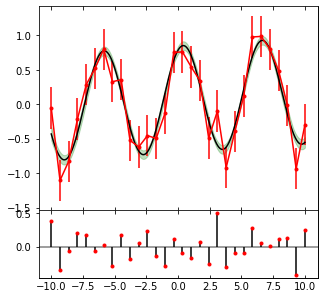

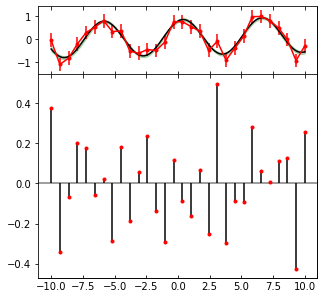

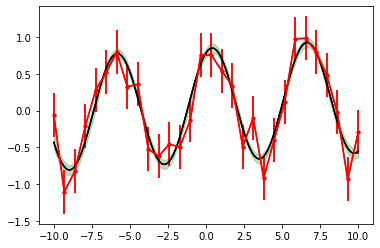

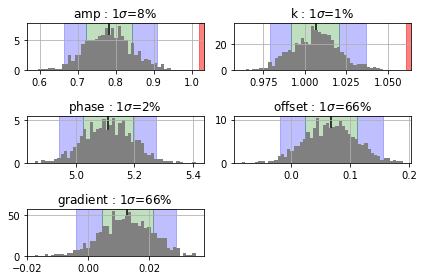

In [98]:
# Fit results and plot and disp
cf = curve_fit(fitfun, guess, x, y_measure, y_error, plot=True, info=True, fitting_method='lm')

# PLots 
cf.plot(fiterrors=True, using=[], divider=0.75)

# Plots 
ax = cf.plot_fitdata()
cf.plot_fiterrors(ax=ax)

ax = cf.bootstrap(plot=True)
display(cf.bs)

          FitValue  FitError Units     Guess  LowerBound  UpperBound  FitError%
amp       0.773191  0.062416  None  0.500000        -inf         inf   8.072512
k         1.007369  0.014640  None  1.000000        -inf         inf   1.453299
phase     5.112664  0.083519  None  3.141593        -inf         inf   1.633570
offset    0.074671  0.045107  None  0.200000        -inf         inf  60.407839
gradient  0.012124  0.007607  None  0.100000        -inf         inf  62.745779


,mean,std,std%,-2 sigma,-1 sigma,+1 sigma,+2 sigma
amp,0.775156,0.061651,7.953302,0.651315,0.712225,0.836235,0.895890
k,1.006879,0.014489,1.439037,0.975936,0.992959,1.020122,1.034669
phase,5.121854,0.078056,1.523978,4.967198,5.047873,5.195029,5.281589
offset,0.068296,0.042445,62.148313,-0.019391,0.026681,0.110862,0.153090
gradient,0.012457,0.008749,70.233306,-0.005237,0.003774,0.021189,0.029534


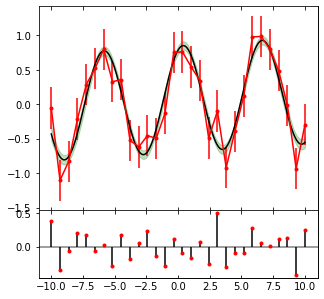

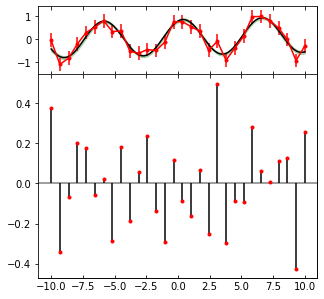

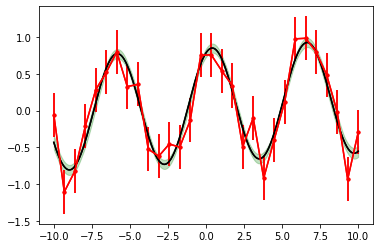

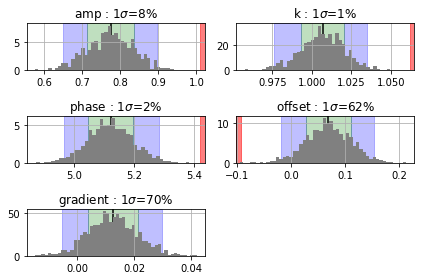

In [99]:
# Fit results and plot and disp
cf = curve_fit(fitfun, guess, x, y_measure, y_error, plot=True, info=True, fitting_method='trf')

# PLots 
cf.plot(fiterrors=True, using=[], divider=0.75)

# Plots 
ax = cf.plot_fitdata()
cf.plot_fiterrors(ax=ax)

ax = cf.bootstrap(plot=True)
display(cf.bs)

          FitValue  FitError Units     Guess  LowerBound  UpperBound   FitError%
amp       0.920527  0.090354  None  0.500000        -inf         inf    9.815447
k         0.998010  0.018021  None  1.000000        -inf         inf    1.805669
phase     5.070484  0.102347  None  3.141593        -inf         inf    2.018494
offset   -0.039227  0.065638  None  0.000000        -inf         inf  167.330054
gradient  0.009581  0.011045  None  0.000000        -inf         inf  115.281634


,mean,std,std%,-2 sigma,-1 sigma,+1 sigma,+2 sigma
amp,0.936354,0.089770,9.587184,0.759276,0.848463,1.025901,1.112709
k,0.997506,0.020712,2.076367,0.956829,0.977204,1.018007,1.036320
phase,5.066570,0.101805,2.009353,4.872248,4.964046,5.170944,5.270566
offset,-0.038409,0.064712,168.482847,-0.157825,-0.103699,0.027077,0.093606
gradient,0.009875,0.010890,110.277393,-0.010550,-0.000476,0.020549,0.032021


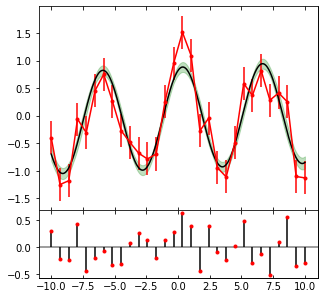

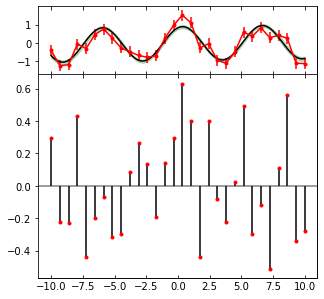

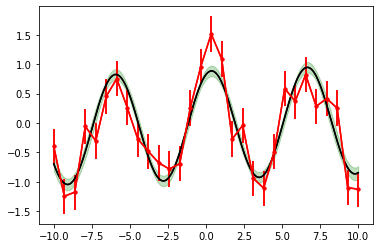

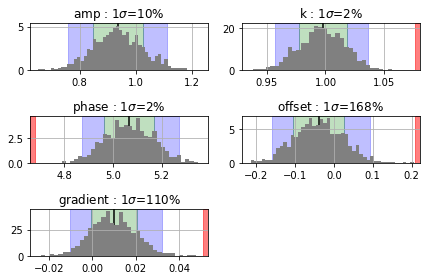

In [100]:
# Tests 
x = np.linspace(-10, 10, 30)
y_exact = 0.87654 * np.sin(0.987 * x + 1.2345) - 0.0345 + 0.01 * x 
y_measure = y_exact + np.random.normal(loc=0, scale=0.3, size=x.size)
y_error = 0.3 * np.ones_like(y_exact)

# Define a fitting function 
def fitfun(x, amp=1, k=1, phase=1, offset=0, gradient=0):
    return amp*np.sin(k*x - phase) + offset + x * gradient
# Guess for the fit 
guess = dict(amp=0.5, k=1, phase=np.pi, offset=0, gradient=0) # Option 2 : dict of guess parameters 
# Fit results and plot and disp
cf = curve_fit(fitfun, guess, x, y_measure, y_error, plot=True, info=True)

# PLots 
cf.plot(fiterrors=True, using=[], divider=0.75)

# Plots 
ax = cf.plot_fitdata()
cf.plot_fiterrors(ax=ax)

ax = cf.bootstrap(plot=True)
display(cf.bs)

          FitValue  FitError    Units  Guess  LowerBound  UpperBound   FitError%
amp       0.817841  0.062419     arb.   0.50        -1.0    2.000000    7.632156
k         0.984630  0.013919      1/m   1.00         0.0    2.000000    1.413622
phase     5.171431  0.079310  Radians   3.14         0.0    6.283185    1.533623
offset    0.018226  0.045259     arb.   0.00        -1.0    1.000000  248.320657
gradient  0.016921  0.007667     None   0.00        -inf         inf   45.309714


,mean,std,std%,-2 sigma,-1 sigma,+1 sigma,+2 sigma
amp,0.826879,0.057992,7.013302,0.711744,0.769756,0.883076,0.947404
k,0.985952,0.016561,1.679687,0.955568,0.969334,1.002044,1.017593
phase,5.175722,0.084592,1.634409,5.011824,5.086420,5.260039,5.348620
offset,0.017482,0.046241,264.500880,-0.070578,-0.029364,0.063863,0.118417
gradient,0.016271,0.008597,52.834258,-0.001082,0.008213,0.025124,0.034186


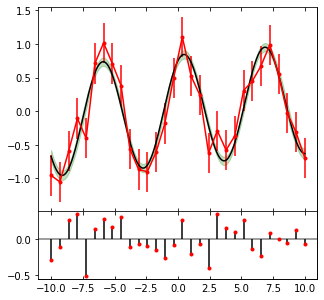

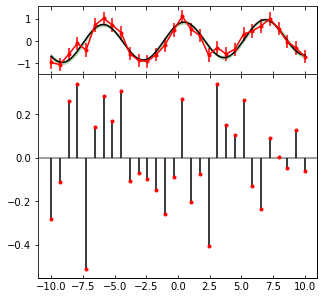

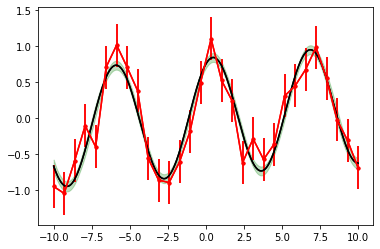

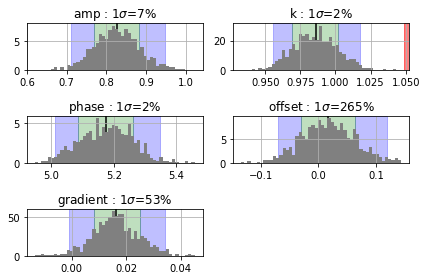

In [101]:
# Tests 
x = np.linspace(-10, 10, 30)
y_exact = 0.87654 * np.sin(0.987 * x + 1.2345) - 0.0345 + 0.01 * x 
y_measure = y_exact + np.random.normal(loc=0, scale=0.3, size=x.size)
y_error = 0.3 * np.ones_like(y_exact)

# Define a fitting function 
def fitfun(x, amp=1, k=1, phase=1, offset=0, gradient=0):
    return amp*np.sin(k*x - phase) + offset + x * gradient
# Guess for the fit 
guess = dict(amp=[0.5, (-1, 2), "arb."], k=[1, (0, 2), "1/m"], phase=[3.14, (0, 2*np.pi), "Radians"], 
             offset=[0, (-1, 1), 'arb.'], gradient=0) # Option 3 : dict of guess with individual having [guess_value, limits, units]
# Fit results and plot and disp
cf = curve_fit(fitfun, guess, x, y_measure, y_error, plot=True, info=True)

# PLots 
cf.plot(fiterrors=True, using=[], divider=0.75)

# Plots 
ax = cf.plot_fitdata()
cf.plot_fiterrors(ax=ax)

ax = cf.bootstrap(plot=True)
display(cf.bs)

In [102]:
# Test robust fitting 

# Tests 
x = np.linspace(-10, 10, 30)
y_exact = 0.87654 * np.sin(0.987 * x + 1.2345) - 0.0345 
y_measure = y_exact + np.random.normal(loc=0, scale=0.3, size=x.size)
y_error = 0.2 * np.ones_like(y_exact)
# Add large amount of noise to select data points 
large_noise_points = 5
y_measure[np.random.randint(0, len(x), large_noise_points)] = np.random.normal(loc=0, scale=2, size=large_noise_points)
loss_function = 'cauchy'
noise_level = 0.5

# Define a fitting function 
def fitfun(x, amp=1, k=1, phase=1, offset=0, gradient=0):
    return amp*np.sin(k*x + phase) + offset + x * gradient
# Guess for the fit 
guess = guess = [0.87, 1, 1.23, -0.03 ]

          FitValue  FitError Units  Guess  LowerBound  UpperBound   FitError%
amp       0.707314  0.225876  None   0.87        -inf         inf   31.934351
k         0.939729  0.058983  None   1.00        -inf         inf    6.276568
phase     1.410819  0.327915  None   1.23        -inf         inf   23.242856
offset    0.128943  0.166757  None  -0.03        -inf         inf  129.326567
gradient  0.000000  0.000000   NaN   0.00         0.0         0.0    0.000000


,mean,std,std%,-2 sigma,-1 sigma,+1 sigma,+2 sigma
amp,0.853878,0.166659,19.517842,0.513143,0.682332,1.002829,1.182787
k,0.943451,0.085113,9.021483,0.815739,0.862881,1.008391,1.154360
phase,1.396946,0.472730,33.840247,0.452347,1.012183,1.857316,2.327977
offset,0.116457,0.143195,122.958959,-0.119276,-0.021816,0.252284,0.461990


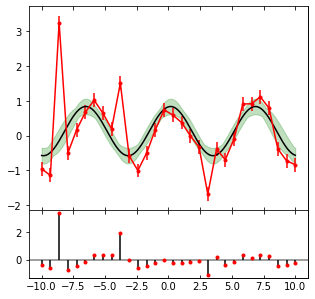

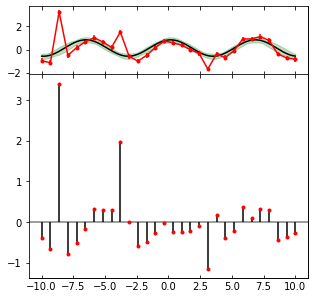

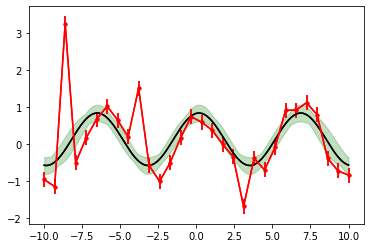

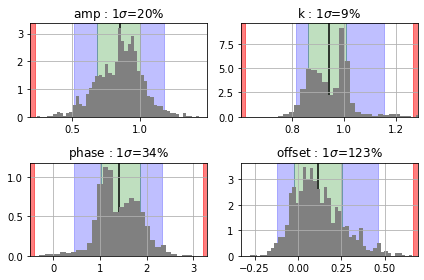

In [103]:
# Fit results and plot and disp
cf = curve_fit(fitfun, guess, x, y_measure, y_error, plot=True, info=True)

# PLots 
cf.plot(fiterrors=True, using=[], divider=0.75)

# Plots 
ax = cf.plot_fitdata()
cf.plot_fiterrors(ax=ax)

ax = cf.bootstrap(plot=True)
display(cf.bs)

          FitValue  FitError Units  Guess  LowerBound  UpperBound   FitError%
amp       0.969933  0.086794  None   0.87        -inf         inf    8.948480
k         0.991708  0.013389  None   1.00        -inf         inf    1.350064
phase     1.119100  0.077046  None   1.23        -inf         inf    6.884658
offset   -0.020669  0.056910  None  -0.03        -inf         inf  275.346070
gradient  0.000000  0.000000   NaN   0.00         0.0         0.0    0.000000


,mean,std,std%,-2 sigma,-1 sigma,+1 sigma,+2 sigma
amp,0.978121,0.086976,8.892183,0.753253,0.896672,1.057036,1.129656
k,0.990369,0.018002,1.817662,0.954901,0.973418,1.006833,1.031505
phase,1.163160,0.090705,7.798175,0.973245,1.092150,1.251277,1.368044
offset,-0.021463,0.068384,318.620620,-0.173990,-0.085227,0.029798,0.133817


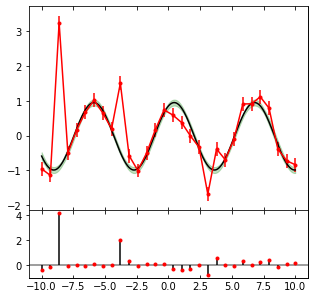

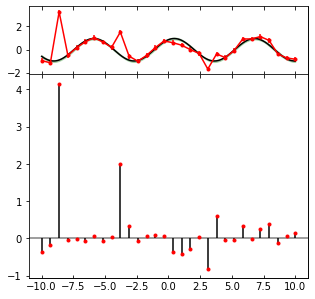

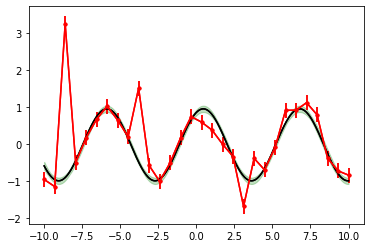

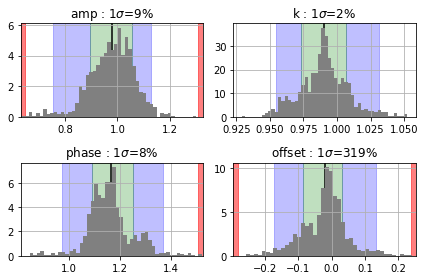

In [105]:
# Fit results and plot and disp
cf = curve_fit(fitfun, guess, x, y_measure, y_error, loss_function=loss_function, 
               noise_level=noise_level, plot=True, info=True)

# PLots 
cf.plot(fiterrors=True, using=[], divider=0.75)

# Plots 
ax = cf.plot_fitdata()
cf.plot_fiterrors(ax=ax)

ax = cf.bootstrap(plot=True)
display(cf.bs)

          FitValue  FitError    Units  Guess  LowerBound  UpperBound   FitError%
amp       1.009649  0.060761     arb.  0.870        -2.0    2.000000    6.018040
k         0.964531  0.007707      1/m  0.987         0.0    2.000000    0.798996
phase     1.182837  0.054314  Radians  1.230         0.0    6.283185    4.591831
offset   -0.006814  0.039928     arb. -0.030        -1.0    1.000000  585.980134
gradient  0.000000  0.000000      NaN  0.000         0.0    0.000000    0.000000


,mean,std,std%,-2 sigma,-1 sigma,+1 sigma,+2 sigma
amp,1.040869,0.118806,11.414117,0.849893,0.947099,1.154627,1.305117
k,0.968350,0.020083,2.073971,0.933106,0.957078,0.979435,1.012475
phase,1.198181,0.158205,13.203726,1.008785,1.096741,1.308979,1.488676
offset,0.000241,0.078979,999.000000,-0.169689,-0.053228,0.070436,0.209676


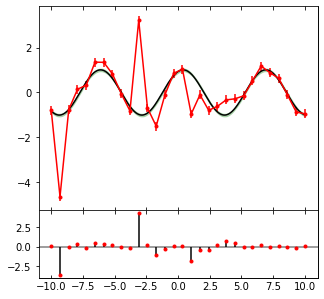

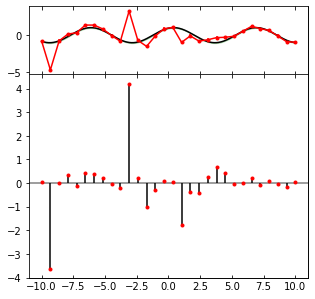

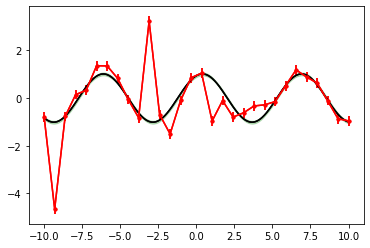

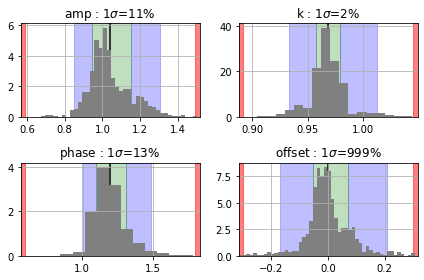

In [91]:
# Test robust fitting 

# Tests 
x = np.linspace(-10, 10, 30)
y_exact = 0.87654 * np.sin(0.987 * x + 1.2345) - 0.0345 
y_measure = y_exact + np.random.normal(loc=0, scale=0.3, size=x.size)
y_error = 0.2 * np.ones_like(y_exact)
# Add large amount of noise to select data points 
large_noise_points = 5
y_measure[np.random.randint(0, len(x), large_noise_points)] = np.random.normal(loc=0, scale=2, size=large_noise_points)
loss_function = 'arctan'
noise_level = 0.5

# Define a fitting function 
def fitfun(x, amp=1, k=1, phase=1, offset=0, gradient=0):
    return amp*np.sin(k*x + phase) + offset + x * gradient
# Guess for the fit 
guess = dict(amp=[0.87, (-2, 2), "arb."], k=[0.987, (0, 2), "1/m"], phase=[1.23, (0, 2*np.pi), "Radians"], 
             offset=[-0.03, (-1, 1), 'arb.']) # Option 3 : dict of guess with individual having [guess_value, limits, units]
# Fit results and plot and disp
cf = curve_fit(fitfun, guess, x, y_measure, y_error, loss_function=loss_function, noise_level=noise_level, plot=True, info=True)

# PLots 
cf.plot(fiterrors=True, using=[], divider=0.75)

# Plots 
ax = cf.plot_fitdata()
cf.plot_fiterrors(ax=ax)

ax = cf.bootstrap(plot=True)
display(cf.bs)